In [1]:
import datetime

import arviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as aet
from scipy.special import expit as logistic
import arviz as az
from scipy import stats

import statsmodels.api as sm
import scipy.stats as stats

import matplotlib.patheffects as path_effects
from itertools import product
import datetime as dt
from tqdm import tqdm
import seaborn as sns
sns.set_style("whitegrid")

def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))
def logit(p):
    return np.log(p)-np.log(1-p)

def add_event_markers(ax, events, height):
    for date, event in events:
        ax.axvline(x=date, color='green', linestyle='--', linewidth=2)
        ax.text(date, height, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=12)

df_state = pd.read_csv("../Data/clean/state_code.csv")

In [2]:
election_date = dt.datetime(2020, 11, 4)

swing_states = ['NV','AZ','PA','NC','MI','GA','WI','NH']

events = [
            (dt.datetime(2020,  3, 11), 'COVID-19 National Emergency Declaration'),
            (dt.datetime(2020,  2,  3), 'Iowa Caucus'),
            (dt.datetime(2020,  3,  3), 'Super Tuesday'),
            (dt.datetime(2020,  4,  8), 'Bernie Withdraws, Biden Presum. Nominee'),
            (dt.datetime(2020,  5, 25), 'Murder of George Floyd'),
            (dt.datetime(2020,  8, 11), 'Kamala Harris Chosen as VP Candidate'),
            (dt.datetime(2020,  8, 17), 'Democratic National Convention'),
            (dt.datetime(2020,  8, 24), 'Republican National Convention'),
            (dt.datetime(2020,  9, 18), 'Death of RBG'),
            (dt.datetime(2020,  9, 29), 'First Debate'),
            (dt.datetime(2020, 10,  7), 'Second Debate'),
            (dt.datetime(2020, 10, 15), 'Final Debate'),
            (dt.datetime(2020, 11,  3), 'Election Day'),
]

events_sig = [ #UPDATE
            (dt.datetime(2020, 11,  3), 'Election Day'),
]

blue_states = []
red_states = []

def missing_states(df_winner): #UPDATE
    df_winner[red_states] = 'gop'
    df_winner[blue_states] = 'dem'
    
    df_winner['NE-1'] = df_winner['NE']
    df_winner['NE-2'] = df_winner['NE']
    df_winner['NE-3'] = df_winner['NE']
    
def best_pollsters(party, idata):
    avg_effect = (
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="YouGov") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="Monmouth") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="Siena/NYT") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="ABC/Washington Post") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="Ipsos")
    ).values / 5
    
    return avg_effect


In [3]:
year = election_date.year
election_year = dt.datetime(election_date.year, 1, 1)
df_actual_results = pd.read_csv(f"../Data/clean/{year}_president_results.csv")

In [4]:
president_polls_url = 'https://projects.fivethirtyeight.com/polls/data/president_polls_historical.csv'
df = pd.read_csv(president_polls_url)
df.to_csv("../Data/raw/president_polls_historical.csv")

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_54268/3546669014.py:2: DtypeWarning: Columns (16,17,26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(president_polls_url)


In [5]:
df = pd.read_csv("../Data/raw/president_polls_historical.csv")

df_state = pd.read_csv("../Data/clean/state_code.csv")

df.loc[df['party'].isin(['REP', 'DEM']) == False, 'party'] = 'OTH'
df = df[df['party'] != 'OTH']

df['start_date'] = pd.to_datetime(df['start_date'])
df['end_date'] = pd.to_datetime(df['end_date'])

df['median_date'] = df['start_date'] + (df['end_date'] - df['start_date']) / 2
df.median_date = df.median_date.dt.round('D')

df['date'] = df.median_date
df = df[df['date'] >= '2020-01-01'] #Only polls during election year
df['week'] = (df['date'] - pd.Timestamp('2020-11-04')).dt.days // 7
df['day'] = (df['date'] - pd.Timestamp('2020-11-04')).dt.days

df = df.merge(df_state[['state','state_code']], how='left')
df.fillna({'state_code':"US"}, inplace=True)
df['state'] = df['state_code']

df = df.set_index('date')
df = df[["poll_id", "question_id", "pollster_id", "pollster", "methodology", "state", 'population', 'sample_size', 'cycle', 'election_date', 'week', 'day', 'party', 'answer',
       'candidate_id', 'candidate_name', 'pct']]

df['year'] = df.index.year
df['month'] = df.index.month

df = df.dropna()

df2 = df.groupby(['poll_id','question_id']).filter(lambda x: set(x['answer']) == {'Trump', 'Biden'})

df_count = df2.pivot(index=['poll_id', 'question_id'], columns='party', values='pct').reset_index()
df_polls = df2.reset_index()[['poll_id', 'question_id', 'pollster_id', 'pollster', 'methodology',
       'state', 'population', 'sample_size', 'cycle', 'election_date','date', 'year', 'month', 'day', 'week']].drop_duplicates()

df_2way = df_polls.merge(df_count)
df_2way = df_2way.rename(columns={'REP':'GOP'})
df_2way['type'] = '2way'

df_2way[['DEM', 'GOP']] = df_2way[['DEM', 'GOP']].div(100)

df = df_2way
df.dropna()
df['obs_id'] = range(len(df))
df['OTHER'] = 1 - (df['DEM'] + df['GOP'])

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_54268/2925199432.py:1: DtypeWarning: Columns (17,18,27,29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../Data/raw/president_polls_historical.csv")
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_54268/2925199432.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['start_date'] = pd.to_datetime(df['start_date'])
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_54268/2925199432.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['end_date'] = pd.to_datetime(df['end_date'])


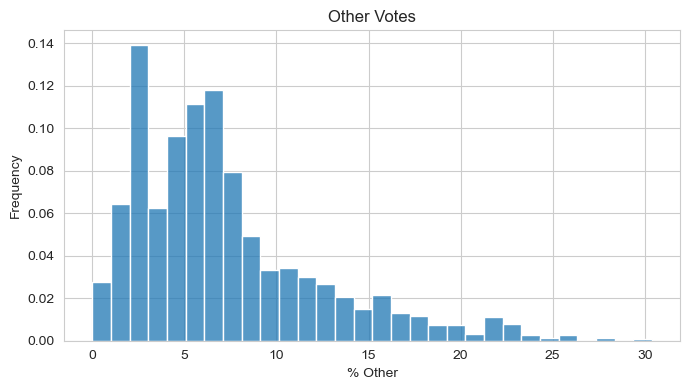

In [6]:
fig, ax = plt.subplots(figsize=(7, 4))

bin_width = 1
max_value = (100 * df.query("state == 'US'")['OTHER']).max()
bins = int(max_value / bin_width)

sns.histplot(100 * df.query("state == 'US'")['OTHER'], bins=bins, stat="probability")
plt.xlabel('% Other')
plt.ylabel('Frequency')
plt.title('Other Votes')

plt.tight_layout()
plt.savefig('weekly_polls.png')
plt.show()

In [7]:
df = df.query("OTHER > 0")
df = df[df['state'].isin(df['state'].value_counts()[df['state'].value_counts() >= 10].index)]

In [8]:
df[['DEM', 'GOP', 'OTHER']].describe()

,DEM,GOP,OTHER
count,5792.000000,5792.000000,5792.000000
mean,0.502668,0.447524,0.049808
std,0.079022,0.080965,0.040778
min,0.214800,0.050000,0.000900
25%,0.460000,0.410000,0.020000
50%,0.500000,0.440000,0.030000
75%,0.530000,0.486000,0.070000
max,0.940000,0.782800,0.304000


In [9]:
POLLSTERS = df.query("state == 'US'")['pollster'].sort_values().unique()
POLLSTERS_top = df.query("state == 'US'").groupby('pollster').size().sort_values(ascending=False).head(20).index.values

STATES = df['state'].sort_values().unique()
STATES_top = df.groupby('state').size().sort_values(ascending=False).head(20).index.values

POPULATIONS = df.query("state == 'US'")['population'].sort_values().unique()
POPULATIONS_top = df.query("state == 'US'").groupby('population').size().sort_values(ascending=False).head(10).index.values

df = df.reset_index()

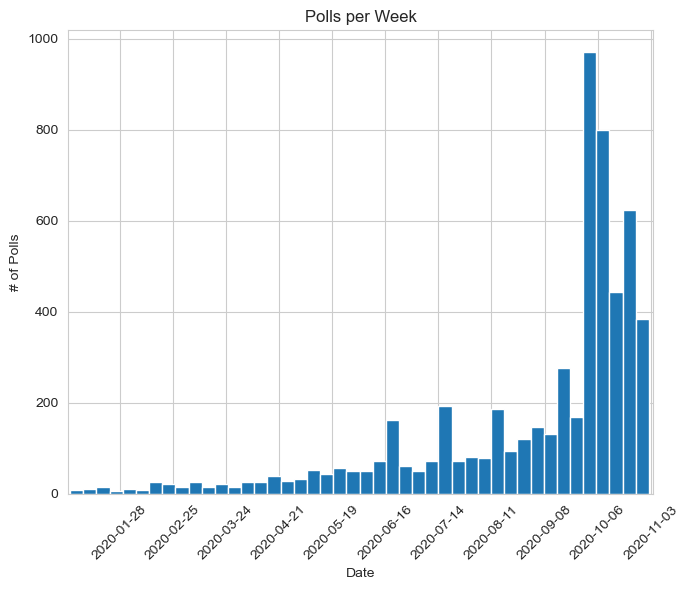

In [10]:
fig, ax = plt.subplots(figsize=(7, 6))

df['date'].hist(bins=len(df['week'].unique()), ax=ax)

ax.set_xlim([election_year, election_date])
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(plt.matplotlib.dates.WeekdayLocator(interval=4))
plt.xticks(rotation=45)

plt.xlabel('Date')
plt.ylabel('# of Polls')
plt.title('Polls per Week')

plt.tight_layout()
plt.show()

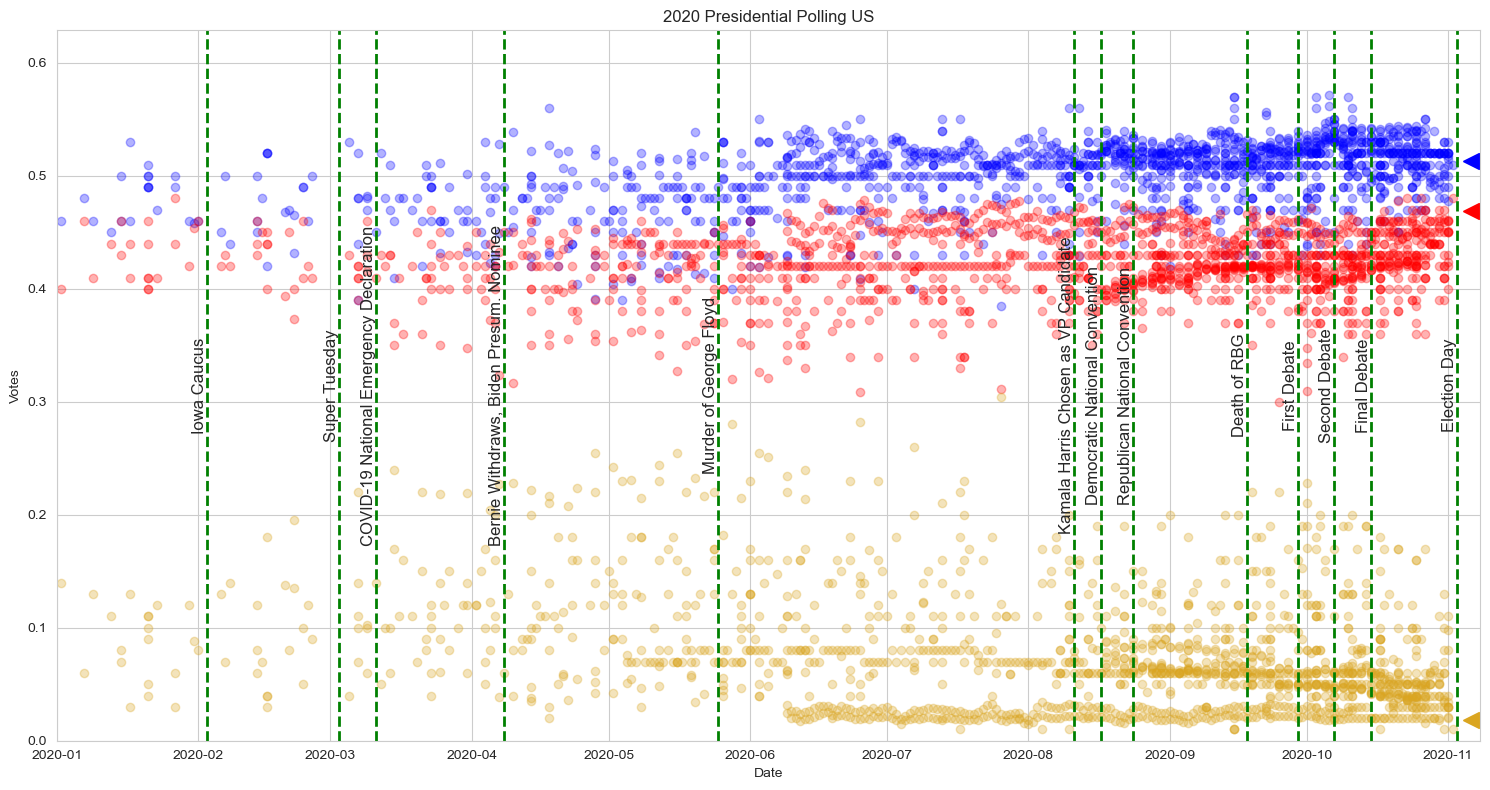

In [11]:
graph_state = 'US'

dem_votes = df.query(f"state == '{graph_state}'")["DEM"].values
gop_votes = df.query(f"state == '{graph_state}'")["GOP"].values
oth_votes = df.query(f"state == '{graph_state}'")["OTHER"].values

dates = df.query(f"state == '{graph_state}'").set_index('date').index

fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(dates, dem_votes, "o", alpha=0.3, color='blue', label="Biden")
ax.plot(dates, gop_votes, "o", alpha=0.3, color='red', label="Trump")
ax.plot(dates, oth_votes, "o", alpha=0.3, color='goldenrod', label="Other")

ax.set_ylim(0, df.query(f"state == '{graph_state}'")[["DEM", "GOP"]].max().max()*1.1)
ax.set_xlim([election_year, election_date + dt.timedelta(days=4)])
ax.set_ylabel('Votes')
ax.set_xlabel('Date')
ax.set_title(f'{year} Presidential Polling {graph_state}')

add_event_markers(ax, events, df.query(f"state == '{graph_state}'")[["DEM", "GOP"]].max().max()*1.1/2)

ax.plot(election_date + dt.timedelta(days=2), df_actual_results.query(f"State == '{graph_state}'")['DEM'], "<", markersize=12, color='blue', alpha=1, label='Actual Margin')
ax.plot(election_date + dt.timedelta(days=2), df_actual_results.query(f"State == '{graph_state}'")['GOP'], "<", markersize=12, color='red', alpha=1)
ax.plot(election_date + dt.timedelta(days=2), df_actual_results.query(f"State == '{graph_state}'")['OTHER'], "<", markersize=12, color='goldenrod', alpha=1)

plt.tight_layout()
plt.show()

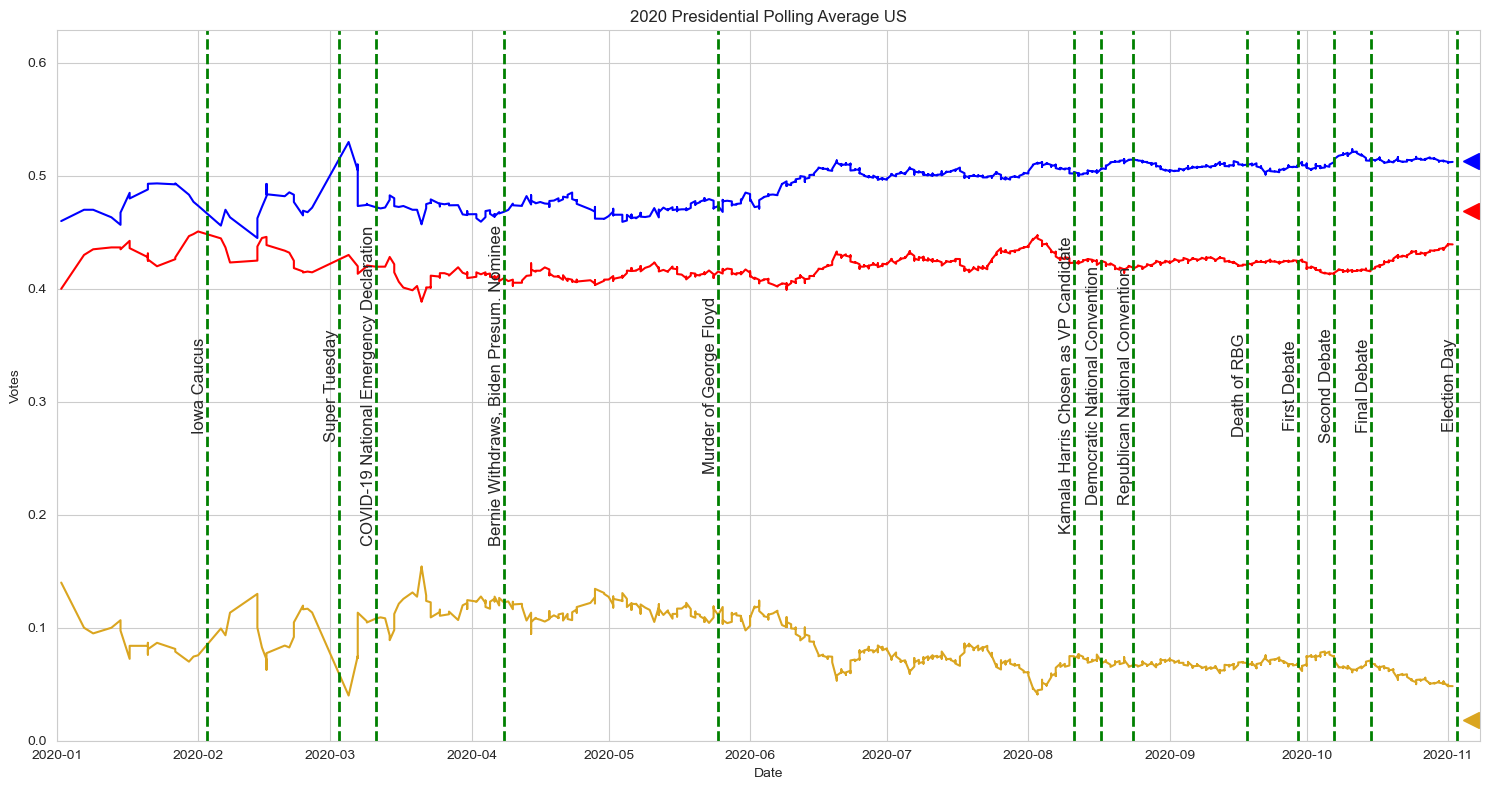

In [12]:
graph_state = 'US'

rolling_mean = (
    df.query(f"state == '{graph_state}'")[["date", "DEM", "GOP", "OTHER"]]
    .set_index("date")
    .sort_index()
    .rolling(window='7D')
    .mean()
    .reset_index()[["date", "DEM", "GOP", "OTHER"]]
    .dropna()
)

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(
    rolling_mean.date,
    rolling_mean.DEM.values,
    color = 'blue',
    alpha=1,
)
ax.plot(
    rolling_mean.date,
    rolling_mean.GOP.values,
    color = 'red',
    alpha=1,
)
ax.plot(
    rolling_mean.date,
    rolling_mean.OTHER.values,
    color = 'goldenrod',
    alpha=1,
)

ax.set_ylim(0, df.query(f"state == '{graph_state}'")[["DEM", "GOP"]].max().max()*1.1)
ax.set_xlim([election_year, election_date + dt.timedelta(days=4)])
ax.set_ylabel('Votes')
ax.set_xlabel('Date')
ax.set_title(f'{year} Presidential Polling Average {graph_state}')

add_event_markers(ax, events, df.query(f"state == '{graph_state}'")[["DEM", "GOP"]].max().max()*1.1/2)

ax.plot(election_date + dt.timedelta(days=2), df_actual_results.query(f"State == '{graph_state}'")['DEM'], "<", markersize=12, color='blue', alpha=1, label='Actual Margin')
ax.plot(election_date + dt.timedelta(days=2), df_actual_results.query(f"State == '{graph_state}'")['GOP'], "<", markersize=12, color='red', alpha=1)
ax.plot(election_date + dt.timedelta(days=2), df_actual_results.query(f"State == '{graph_state}'")['OTHER'], "<", markersize=12, color='goldenrod', alpha=1)

plt.tight_layout()
plt.show()

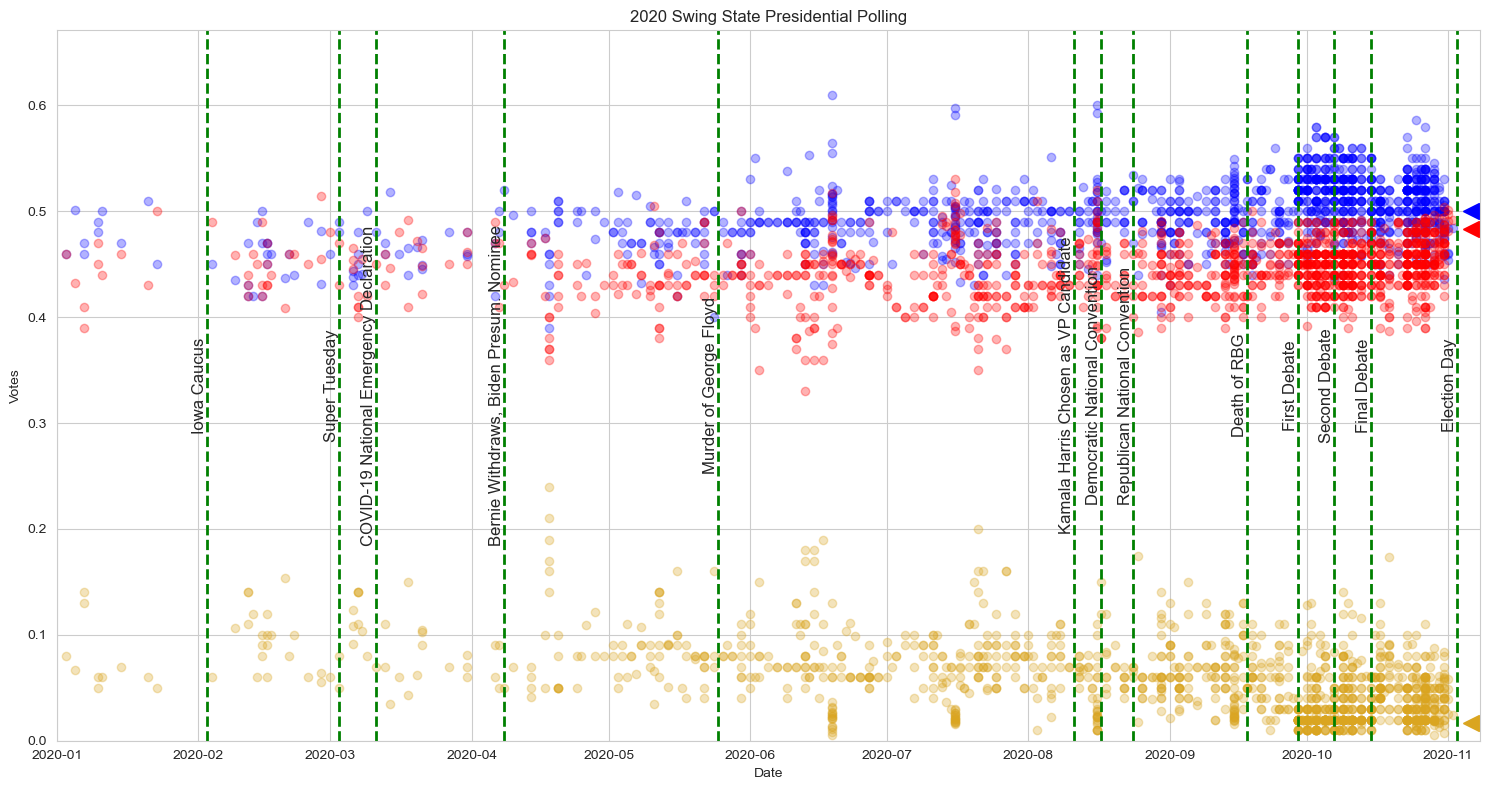

In [13]:
dem_votes = df.query(f"state in {swing_states}")["DEM"].values
gop_votes = df.query(f"state in {swing_states}")["GOP"].values
oth_votes = df.query(f"state in {swing_states}")["OTHER"].values

dates = df.query(f"state in {swing_states}").set_index('date').index

fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(dates, dem_votes, "o", alpha=0.3, color='blue', label="Biden")
ax.plot(dates, gop_votes, "o", alpha=0.3, color='red', label="Trump")
ax.plot(dates, oth_votes, "o", alpha=0.3, color='goldenrod', label="Other")

ax.set_ylim(0, df.query(f"state in {swing_states}")[["DEM", "GOP", "OTHER"]].max().max()*1.1)
ax.set_xlim([election_year, election_date + dt.timedelta(days=4)])
ax.set_ylabel('Votes')
ax.set_xlabel('Date')
ax.set_title(f"{year} Swing State Presidential Polling")

add_event_markers(ax, events, df.query(f"state in {swing_states}")[["DEM", "GOP", "OTHER"]].max().max()*1.1/2)

ax.plot(election_date + dt.timedelta(days=2), df_actual_results.query(f"State in {swing_states}").DEM.mean(), "<", markersize=12, color='blue', alpha=1, label='Actual Margin')
ax.plot(election_date + dt.timedelta(days=2), df_actual_results.query(f"State in {swing_states}").GOP.mean(), "<", markersize=12, color='red', alpha=1)
ax.plot(election_date + dt.timedelta(days=2), df_actual_results.query(f"State in {swing_states}").OTHER.mean(), "<", markersize=12, color='goldenrod', alpha=1)

plt.tight_layout()
plt.show()

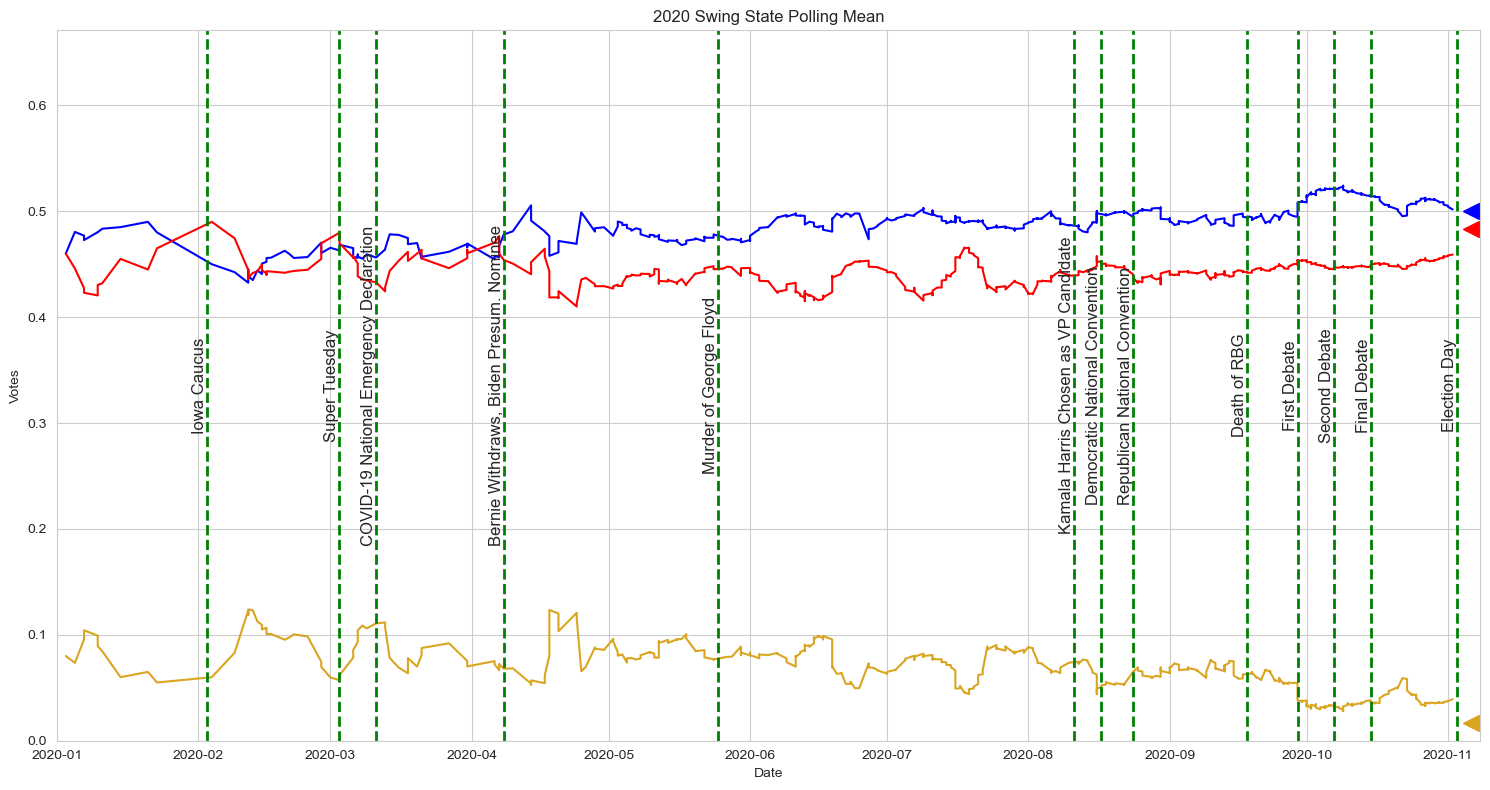

In [14]:
rolling_mean = (
    df.query(f"state in {swing_states}")[["date", "DEM", "GOP", "OTHER"]]
    .set_index("date")
    .sort_index()
    .rolling(window='7D')
    .mean()
    .reset_index()[["date", "DEM", "GOP", "OTHER"]]
    .dropna()
)

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(
    rolling_mean.date,
    rolling_mean.DEM.values,
    color = 'blue',
    alpha=1,
)
ax.plot(
    rolling_mean.date,
    rolling_mean.GOP.values,
    color = 'red',
    alpha=1,
)
ax.plot(
    rolling_mean.date,
    rolling_mean.OTHER.values,
    color = 'goldenrod',
    alpha=1,
)

ax.set_ylim(0, df.query(f"state in {swing_states}")[["DEM", "GOP", "OTHER"]].max().max()*1.1)
ax.set_xlim([election_year, election_date + dt.timedelta(days=4)])
ax.set_ylabel('Votes')
ax.set_xlabel('Date')
ax.set_title(f"{year} Swing State Polling Mean")

add_event_markers(ax, events, df.query(f"state in {swing_states}")[["DEM", "GOP", "OTHER"]].max().max()*1.1/2)

ax.plot(election_date + dt.timedelta(days=2), df_actual_results.query(f"State in {swing_states}").DEM.mean(), "<", markersize=12, color='blue', alpha=1, label='Actual Margin')
ax.plot(election_date + dt.timedelta(days=2), df_actual_results.query(f"State in {swing_states}").GOP.mean(), "<", markersize=12, color='red', alpha=1)
ax.plot(election_date + dt.timedelta(days=2), df_actual_results.query(f"State in {swing_states}").OTHER.mean(), "<", markersize=12, color='goldenrod', alpha=1)

plt.tight_layout()
plt.show()

In [15]:
df["margin"] = df.apply(lambda row: (row['DEM'] - row['GOP']), axis=1)

df = (
    df.reset_index()
    .merge(
        df.groupby(["week"])[["GOP", "DEM", "margin"]].mean().reset_index(),
        on=["week"],
        suffixes=["", "_mean"],
    )
    .rename(columns={"index": "field_date"})
)

df["diff_GOP"] = df["GOP"] - df["GOP_mean"]
df["diff_DEM"] = df["DEM"] - df["DEM_mean"]

df["diff_margin"] = df["margin"] - df["margin_mean"]

x_res = np.maximum(df.query("state == 'US'").margin.quantile(q=1), df.query("state == 'US'").margin.quantile(q=0) * -1)

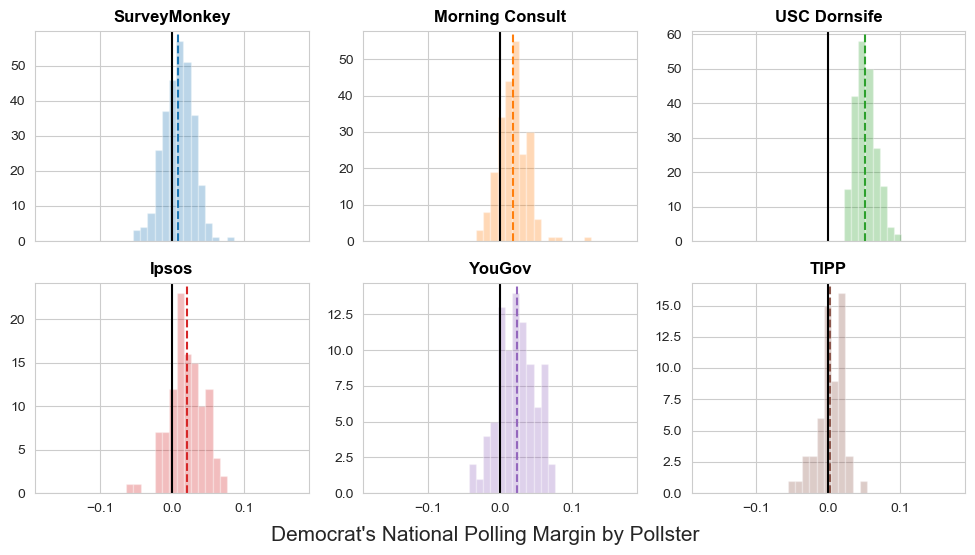

In [16]:
POLLSTER_VALS = {
    pollster: df.query("state == 'US'")[df.query("state == 'US'")["pollster"] == pollster]["diff_margin"].values
    for pollster in list(POLLSTERS_top)
}

colors = plt.rcParams["axes.prop_cycle"]()

fig, axes = plt.subplots(ncols=3, nrows=2, sharex=True, figsize=(12, 6))

for ax, (pollster, vals) in zip(axes.ravel(), POLLSTER_VALS.items()):
    c = next(colors)["color"]
    bin_width = 0.01
    min_edge = vals.min()
    max_edge = vals.max()
    bins = np.arange(min_edge, max_edge + bin_width, bin_width)
    ax.hist(vals, bins=bins, alpha=0.3, color=c, label=pollster)
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")
    ax.axvline(x=0, color="black")
    ax.set_xlim(-x_res, x_res)
    
    ax.text(0.5, 1.1, pollster, color='black', fontsize=12, 
            ha='center', va='top', transform=ax.transAxes, weight='bold')
    
fig.text(0.5, 0.03, r"Democrat's National Polling Margin by Pollster", ha='center', fontsize=15)

plt.show()

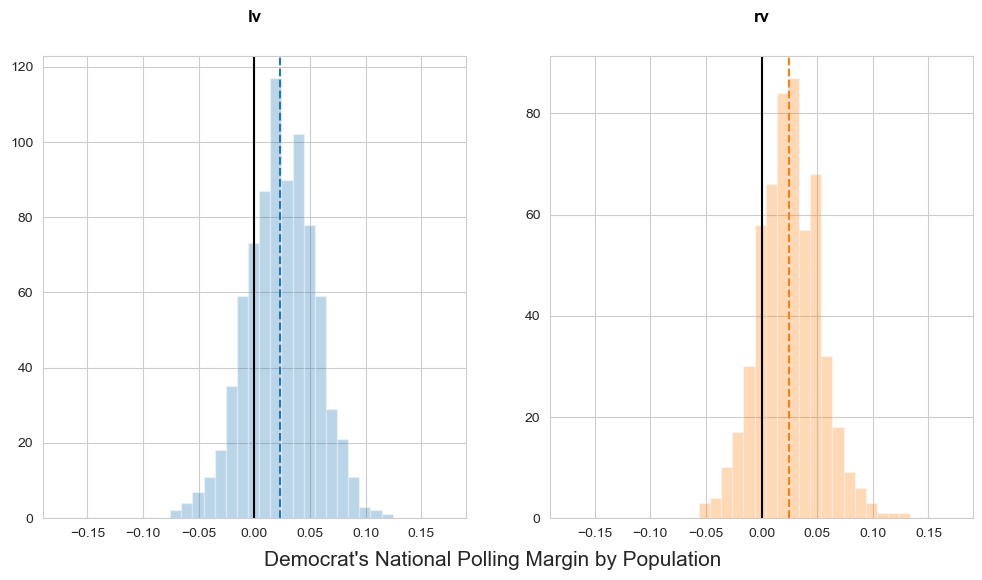

In [17]:
POPULATIONS_VALS = {
    population: df.query("state == 'US'")[df.query("state == 'US'")["population"] == population]["diff_margin"].values
    for population in list(POPULATIONS_top)
}

colors = plt.rcParams["axes.prop_cycle"]()

fig, axes = plt.subplots(ncols=2, nrows=1, sharex=True, figsize=(12, 6))

for ax, (pollster, vals) in zip(axes.ravel(), POPULATIONS_VALS.items()):
    c = next(colors)["color"]
    bin_width = 0.01
    min_edge = vals.min()
    max_edge = vals.max()
    bins = np.arange(min_edge, max_edge + bin_width, bin_width)
    ax.hist(vals, bins=bins, alpha=0.3, color=c, label=pollster)
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")
    ax.axvline(x=0, color="black")
    ax.set_xlim(-x_res, x_res)
    
    ax.text(0.5, 1.1, pollster, color='black', fontsize=12, 
            ha='center', va='top', transform=ax.transAxes, weight='bold')
    
fig.text(0.5, 0.03, r"Democrat's National Polling Margin by Population", ha='center', fontsize=15)

plt.show()

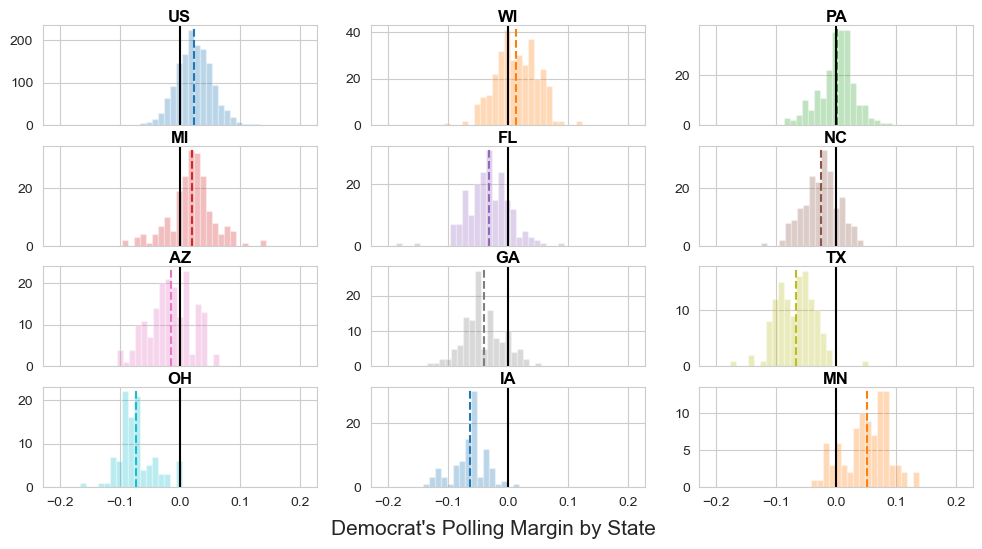

In [18]:
STATE_VALS = {
    state: df[df["state"] == state]["diff_margin"].values
    for state in list(STATES_top)
}

colors = plt.rcParams["axes.prop_cycle"]()

fig, axes = plt.subplots(ncols=3, nrows=4, sharex=True, figsize=(12, 6))

for ax, (pollster, vals) in zip(axes.ravel(), STATE_VALS.items()):
    c = next(colors)["color"]
    bin_width = 0.01
    min_edge = vals.min()
    max_edge = vals.max()
    bins = np.arange(min_edge, max_edge + bin_width, bin_width)
    ax.hist(vals, bins=bins, alpha=0.3, color=c, label=pollster)
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")
    ax.axvline(x=0, color="black")
    ax.set_xlim(-x_res*1.2, x_res*1.2)
    
    ax.text(0.5, 1.15, pollster, color='black', fontsize=12, 
            ha='center', va='top', transform=ax.transAxes, weight='bold')
    
fig.text(0.5, 0.03, r"Democrat's Polling Margin by State", ha='center', fontsize=15)

plt.show()

In [19]:
date_counts = df['date'].value_counts().reset_index()
date_counts.columns = ['date', 'count']
date_counts = date_counts.sort_values(by='date', ascending=False).reset_index(drop=True)

In [20]:
week_id, week = df.set_index(
    ["week"]
).index.factorize(sort=True)

day_id = df.day.to_numpy()
day = np.arange(df.day.min(), 1)

party_id, party = [0,1,2], ['DEM','GOP','Other']

pollster_id, pollster = df.set_index(
    ["pollster"]
).index.factorize(sort=True)

method_id, method = df.set_index(
    ["methodology"]
).index.factorize(sort=True)

state_id, state = df.set_index(
    ["state"]
).index.factorize(sort=True)

population_id, population = df.set_index(
    ["population"]
).index.factorize(sort=True)

COORDS = {
    "pollster": pollster,
    "method": method,
    "state": state,
    "party": party,
    "population": population,
    "week": week,
    "day": day,
    "observation": df.obs_id
}

In [21]:
with pm.Model(coords=COORDS) as twoway:

    epsilon = 1e-6

    dem_sigma       = pm.HalfNormal("dem_sigma", sigma=0.1) + epsilon
    dem_rho         = pm.Normal("dem_rho", mu=0, sigma=0.7)
    dem_ar          = pm.AR("dem_ar",
                            rho=[dem_rho] * 7,
                            sigma=dem_sigma,
                            init_dist=pm.Normal.dist(mu=0, sigma=0.05),
                            dims="day"
                           )
    dem_sigma_rw    = pm.HalfNormal("dem_sigma_rw", sigma=0.1) + epsilon
    dem_random_walk = pm.GaussianRandomWalk("dem_random_walk",
                                            sigma=dem_sigma_rw,
                                            init_dist=pm.Normal.dist(mu=0, sigma=0.3),
                                            dims="day")
    dem_day_effect  = pm.Deterministic("dem_day_effect", dem_ar + dem_random_walk, dims="day")

    dem_pollster_effect = pm.Normal("dem_pollster_effect", 0, 0.5, dims="pollster")
    dem_method_effect   = pm.Normal("dem_method_effect", 0, 0.5, dims="method")
    dem_state_effect    = pm.Normal("dem_state_effect", 0, 0.5, dims="state")
    dem_state_multi     = pm.Normal("dem_state_multi", 1, 0.5, dims="state")
    dem_pop_effect      = pm.Normal("dem_pop_effect", 0, 0.5, dims="population")

    dem_polling = pm.Deterministic("dem_polling", pm.math.invlogit(
        dem_pollster_effect[pollster_id] +
        dem_method_effect[method_id] +
        dem_pop_effect[population_id] +
        dem_state_effect[state_id] +
        dem_state_multi[state_id] *
        dem_day_effect[day_id]
    ),
        dims = "observation")
    
    gop_sigma       = pm.HalfNormal("gop_sigma", sigma=0.1) + epsilon
    gop_rho         = pm.Normal("gop_rho", mu=0, sigma=0.7)
    gop_ar          = pm.AR("gop_ar",
                            rho=[gop_rho] * 7,
                            sigma=gop_sigma,
                            init_dist=pm.Normal.dist(mu=0, sigma=0.05),
                            dims="day"
                           )
    gop_sigma_rw    = pm.HalfNormal("gop_sigma_rw", sigma=0.1) + epsilon
    gop_random_walk = pm.GaussianRandomWalk("gop_random_walk",
                                            sigma=gop_sigma_rw,
                                            init_dist=pm.Normal.dist(mu=0, sigma=0.3),
                                            dims="day")
    gop_day_effect  = pm.Deterministic("gop_day_effect", gop_ar + gop_random_walk, dims="day")

    gop_pollster_effect = pm.Normal("gop_pollster_effect", 0, 0.5, dims="pollster")
    gop_method_effect   = pm.Normal("gop_method_effect", 0, 0.5, dims="method")
    gop_state_effect    = pm.Normal("gop_state_effect", 0, 0.5, dims="state")
    gop_state_multi     = pm.Normal("gop_state_multi", 1, 0.5, dims="state")
    gop_pop_effect      = pm.Normal("gop_pop_effect", 0, 0.5, dims="population")

    gop_polling = pm.Deterministic("gop_polling", pm.math.invlogit(
        gop_pollster_effect[pollster_id] +
        gop_method_effect[method_id] +
        gop_pop_effect[population_id] +
        gop_state_effect[state_id] +
        gop_state_multi[state_id] *
        gop_day_effect[day_id]
    ),
        dims = "observation")

    oth_sigma       = pm.HalfNormal("oth_sigma", sigma=0.1) + epsilon
    oth_rho         = pm.Normal("oth_rho", mu=0, sigma=0.7)
    oth_ar          = pm.AR("oth_ar",
                            rho=[oth_rho] * 7,
                            sigma=oth_sigma,
                            init_dist=pm.Normal.dist(mu=0, sigma=0.05),
                            dims="day"
                           )
    oth_sigma_rw    = pm.HalfNormal("oth_sigma_rw", sigma=0.1) + epsilon
    oth_random_walk = pm.GaussianRandomWalk("oth_random_walk",
                                            sigma=oth_sigma_rw,
                                            init_dist=pm.Normal.dist(mu=0, sigma=0.3),
                                            dims="day")
    oth_day_effect  = pm.Deterministic("oth_day_effect", oth_ar + oth_random_walk, dims="day")

    oth_pollster_effect = pm.Normal("oth_pollster_effect", 0, 0.5, dims="pollster")
    oth_method_effect   = pm.Normal("oth_method_effect", 0, 0.5, dims="method")
    oth_state_effect    = pm.Normal("oth_state_effect", 0, 0.5, dims="state")
    oth_state_multi     = pm.Normal("oth_state_multi", 1, 0.5, dims="state")
    oth_pop_effect      = pm.Normal("oth_pop_effect", 0, 0.5, dims="population")

    oth_polling = pm.Deterministic("oth_polling", pm.math.invlogit(
        oth_pollster_effect[pollster_id] +
        oth_method_effect[method_id] +
        oth_pop_effect[population_id] +
        oth_state_effect[state_id] +
        oth_state_multi[state_id] *
        oth_day_effect[day_id]
    ),
        dims = "observation")

    dem_vote = pm.Binomial(
        "dem_vote",
        p = dem_polling,
        n = df["sample_size"],
        observed = df['sample_size'] * df['DEM'],
        dims = "observation",
    )

    gop_vote = pm.Binomial(
        "gop_vote",
        p = gop_polling,
        n = df["sample_size"],
        observed = df['sample_size'] * df['GOP'],
        dims = "observation",
    )

    oth_vote = pm.Binomial(
        "oth_vote",
        p = oth_polling,
        n = df["sample_size"],
        observed = df['sample_size'] * df['OTHER'],
        dims = "observation",
    )

    polling_error_state_dem = pm.Normal("polling_error_state_dem", 0, 1, dims="state")
    polling_error_state_gop = pm.Deterministic("polling_error_state_gop", -polling_error_state_dem, dims="state")
    polling_error_state_oth = pm.Deterministic("polling_error_state_oth", polling_error_state_dem*0, dims="state")

    idata = pm.sample(draws=1000, cores=10, return_inferencedata=True, step=pm.NUTS(target_accept=0.95), init='advi+adapt_diag')

Multiprocess sampling (10 chains in 10 jobs)
NUTS: [dem_sigma, dem_rho, dem_ar, dem_sigma_rw, dem_random_walk, dem_pollster_effect, dem_method_effect, dem_state_effect, dem_state_multi, dem_pop_effect, gop_sigma, gop_rho, gop_ar, gop_sigma_rw, gop_random_walk, gop_pollster_effect, gop_method_effect, gop_state_effect, gop_state_multi, gop_pop_effect, oth_sigma, oth_rho, oth_ar, oth_sigma_rw, oth_random_walk, oth_pollster_effect, oth_method_effect, oth_state_effect, oth_state_multi, oth_pop_effect, polling_error_state_dem]


Output()

Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 10389 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 5 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 6 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 7 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 8 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 9 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.o

In [22]:
states = df['state'].unique()
parties = ['dem','gop','margin','oth']

combinations = [f"{state}_{party}" for state, party in product(states, parties)]

interim = pd.DataFrame()

for party in ['dem', 'gop', 'oth']:
    pollster_effects = best_pollsters(party, idata)
    pollster_effects_flat = pollster_effects.ravel()
    interim[f"pollster_effects_{party}"] = pollster_effects_flat

    method_effects = (
        idata.posterior[f"{party}_method_effect"].where(idata.posterior[f"{party}_method_effect"].method == 'Live Phone', drop=True).mean(axis=2) +
        idata.posterior[f"{party}_method_effect"].where(idata.posterior[f"{party}_method_effect"].method == 'Probability Panel', drop=True).mean(axis=2)
    ).values /2
    method_effects_flat = method_effects.ravel()
    interim[f"method_effects_{party}"] = method_effects_flat

    pop_effects = (
        idata.posterior[f"{party}_pop_effect"].sel(population="lv")
    ).values
    pop_effects_flat = pop_effects.ravel()
    interim[f"pop_effects_{party}"] = pop_effects_flat

    interim[f"fund_{party}"] = interim[f"pollster_effects_{party}"] + interim[f"method_effects_{party}"] +  interim[f"pop_effects_{party}"]

In [99]:
df_results = pd.DataFrame(columns=combinations)
df_day_mean = pd.DataFrame(index=day, columns=combinations)
df_day_03 =  pd.DataFrame(index=day, columns=combinations)
df_day_25 =  pd.DataFrame(index=day, columns=combinations)
df_day_75 =  pd.DataFrame(index=day, columns=combinations)
df_day_97 =  pd.DataFrame(index=day, columns=combinations)

#for d in [-8]:
for d in tqdm(day):
    day_results = {}
    for state in states:
        for party in ['dem', 'gop', 'oth']:
            polling_error = 0.03 * idata.posterior[f"polling_error_state_{party}"].sel(state=f"{state}").values.ravel() if state == 'US' else 0.067 * idata.posterior[f"polling_error_state_{party}"].sel(state=f"{state}").values.ravel()
            day_results[f"{state}_{party}"] = inv_logit(
                interim[f"fund_{party}"] +
                idata.posterior[f"{party}_state_effect"].sel(state=f"{state}").values.ravel() +
                polling_error +
                idata.posterior[f"{party}_state_multi"].sel(state=f"{state}").values.ravel() *
                (idata.posterior[f"{party}_day_effect"].sel(day=d).values.ravel()
                #+ (.1 if party == 'gop' else 0) # 2% swing towards GOP
                #+ (.05 if party == 'dem' else 0) # 1% swing towards DEM
                )  
            ).to_numpy()

        total = sum(day_results[f"{state}_{party}"] for party in ['dem', 'gop', 'oth'])
        for party in ['dem', 'gop', 'oth']:
            day_results[f"{state}_{party}"] /= total
        
        day_results[f"{state}_margin"] = day_results[f"{state}_dem"] - day_results[f"{state}_gop"]

    df_results = pd.DataFrame(day_results)

    df_day_03.loc[d] = df_results.quantile(0.03)
    df_day_25.loc[d] = df_results.quantile(0.25)
    df_day_mean.loc[d] = df_results.quantile(0.50)
    df_day_75.loc[d] = df_results.quantile(0.75)
    df_day_97.loc[d] = df_results.quantile(0.97)

100%|█████████████████████████████████████████| 308/308 [01:06<00:00,  4.65it/s]


In [100]:
date_index = pd.DataFrame(index = range(min(df_day_mean.index),1), columns = ['date'])
date_index['date'] = pd.date_range(start=df.date.min(), end=election_date)
df_day_mean = df_day_mean.merge(date_index, left_index=True, right_index=True).reset_index().set_index('date')
df_day_03 = df_day_03.merge(date_index, left_index=True, right_index=True).reset_index().set_index('date')
df_day_25 = df_day_25.merge(date_index, left_index=True, right_index=True).reset_index().set_index('date')
df_day_75 = df_day_75.merge(date_index, left_index=True, right_index=True).reset_index().set_index('date')
df_day_97 = df_day_97.merge(date_index, left_index=True, right_index=True).reset_index().set_index('date')

In [101]:
graph_state = 'US'

fig, ax = plt.subplots(figsize=(15, 8))

df_day_mean[f"{graph_state}_dem"].rolling(window='7D').mean().plot(color='blue', label='DEM Polling Mean')
plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_dem"].rolling(window='7D').mean().ffill(), df_day_97[f"{graph_state}_dem"].rolling(window='7D').mean().ffill(), color='blue', alpha=0.2, label='94% HDI')
plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_dem"].rolling(window='7D').mean().ffill(), df_day_75[f"{graph_state}_dem"].rolling(window='7D').mean().ffill(), color='blue', alpha=0.3, label='50% HDI')

df_day_mean[f"{graph_state}_gop"].rolling(window='7D').mean().plot(color='red', label='GOP')
plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_gop"].rolling(window='7D').mean().ffill(), df_day_97[f"{graph_state}_gop"].rolling(window='7D').mean().ffill(), color='red', alpha=0.2)
plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_gop"].rolling(window='7D').mean().ffill(), df_day_75[f"{graph_state}_gop"].rolling(window='7D').mean().ffill(), color='red', alpha=0.3)

df_day_mean[f"{graph_state}_oth"].rolling(window='7D').mean().plot(color='goldenrod', label='Undecided/Third Party')
plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_oth"].rolling(window='7D').mean().ffill(), df_day_97[f"{graph_state}_oth"].rolling(window='7D').mean().ffill(), color='goldenrod', alpha=0.2)
plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_oth"].rolling(window='7D').mean().ffill(), df_day_75[f"{graph_state}_oth"].rolling(window='7D').mean().ffill(), color='goldenrod', alpha=0.3)

ax.set_ylim(0,df_day_97[[f"{graph_state}_dem", f"{graph_state}_gop", f"{graph_state}_oth"]].max().max()*1.1)
ax.set_xlim([election_year, election_date + dt.timedelta(days=4)])
ax.set_ylabel('% Vote')
ax.set_xlabel('Date')
ax.set_title('National Popular Vote')

add_event_markers(ax, events, df_day_97[[f"{graph_state}_dem", f"{graph_state}_gop", f"{graph_state}_oth"]].max().max()*1.1/2)

ax.plot(election_date + dt.timedelta(days=2), df_actual_results.query(f"State == '{graph_state}'")['DEM'], "<", markersize=12, color='blue', alpha=1, label='Actual Margin')
ax.plot(election_date + dt.timedelta(days=2), df_actual_results.query(f"State == '{graph_state}'")['GOP'], "<", markersize=12, color='red', alpha=1)
ax.plot(election_date + dt.timedelta(days=2), df_actual_results.query(f"State == '{graph_state}'")['OTHER'], "<", markersize=12, color='goldenrod', alpha=1)

ax.legend()

plt.tight_layout()
plt.savefig(f'../Results/{year}_president/popular_vote.png')

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_54268/3339419384.py:31: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


ValueError: Image size of 69192x709 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1500x800 with 1 Axes>

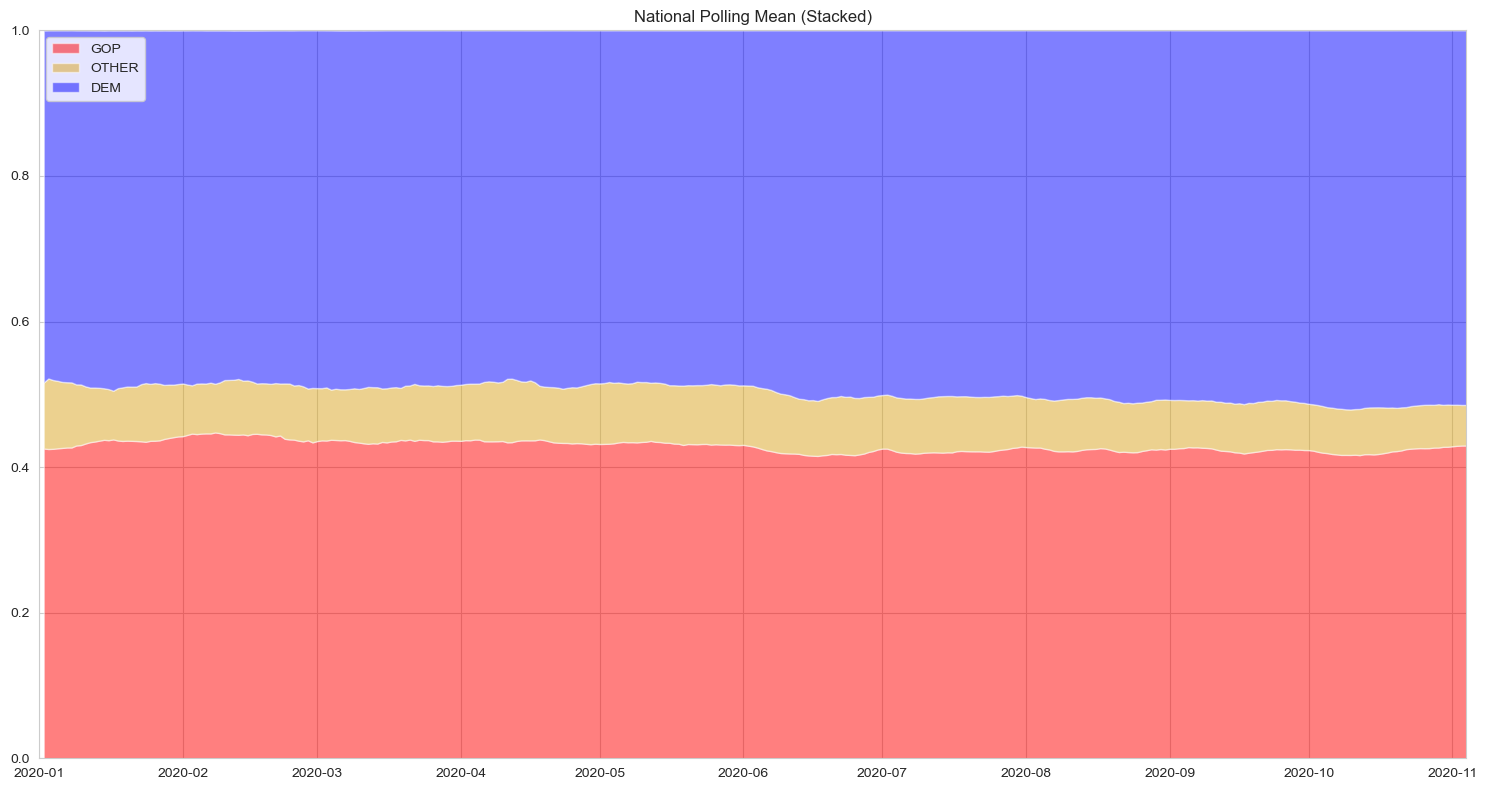

In [102]:
graph_state = 'US'

rolling_mean = (
    df_day_mean[[f"{graph_state}_gop", f"{graph_state}_oth", f"{graph_state}_dem"]]
    .sort_index()
    .rolling(window='7D')
    .mean()
    .reset_index()[["date", f"{graph_state}_gop", f"{graph_state}_oth", f"{graph_state}_dem"]]
    .dropna()
)

fig, ax = plt.subplots(figsize=(15, 8))

ax.stackplot(
    rolling_mean.date,
    rolling_mean[f"{graph_state}_gop"].values,
    rolling_mean[f"{graph_state}_oth"].values,
    rolling_mean[f"{graph_state}_dem"].values,
    labels=["GOP", "OTHER", "DEM"],
    colors=['red', 'goldenrod', 'blue'],
    alpha=.5,
)

ax.set_ylim(0, 1)
ax.set_xlim([election_year, election_date])
ax.set_title("National Polling Mean (Stacked)")
ax.legend(loc='upper left')

plt.tight_layout()
plt.savefig(f'../Results/{year}_president/stacked.png')

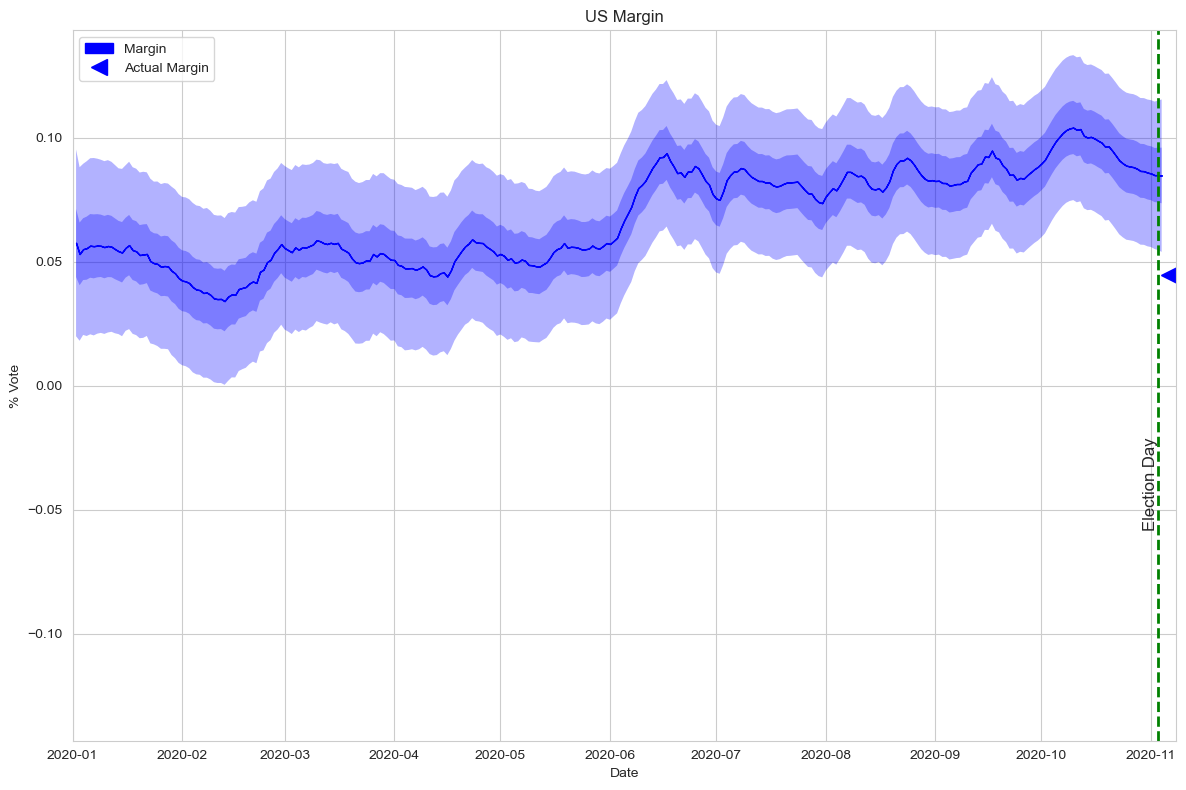

In [103]:
graph_state = 'US'

fig, ax = plt.subplots(figsize=(12, 8))

mean_rolling = df_day_mean[f'{graph_state}_margin'].rolling(window='7D').mean().ffill()
hdi_03_rolling = df_day_03[f'{graph_state}_margin'].rolling(window='7D').mean().ffill()
hdi_97_rolling = df_day_97[f'{graph_state}_margin'].rolling(window='7D').mean().ffill()
hdi_25_rolling = df_day_25[f'{graph_state}_margin'].rolling(window='7D').mean().ffill()
hdi_75_rolling = df_day_75[f'{graph_state}_margin'].rolling(window='7D').mean().ffill()

plt.fill_between(df_day_mean.index, 
                 np.maximum(0,hdi_03_rolling), 
                 np.maximum(hdi_97_rolling,0),
                 where=hdi_97_rolling > 0, 
                 color='blue', alpha=0.3, edgecolor='none')

plt.fill_between(df_day_mean.index, 
                 np.maximum(0,hdi_25_rolling), 
                 np.maximum(hdi_75_rolling,0), 
                 where=hdi_75_rolling > 0, 
                 color='blue', alpha=0.3, edgecolor='none')

plt.fill_between(df_day_mean.index, 
                 np.maximum(0,mean_rolling), 
                 np.maximum(mean_rolling,0), 
                 where=mean_rolling > 0, 
                 color='blue', alpha=1, label='Margin')

plt.fill_between(df_day_mean.index, 
                 np.minimum(0,hdi_03_rolling), 
                 np.minimum(hdi_97_rolling,0),
                 where=hdi_03_rolling < 0, 
                 color='red', alpha=0.3, edgecolor='none')

plt.fill_between(df_day_mean.index, 
                 np.minimum(0,hdi_25_rolling), 
                 np.minimum(hdi_75_rolling,0), 
                 where=hdi_25_rolling < 0, 
                 color='red', alpha=0.3, edgecolor='none')

plt.fill_between(df_day_mean.index, 
                 np.minimum(0,mean_rolling), 
                 np.minimum(mean_rolling,0), 
                 where=mean_rolling < 0, 
                 color='red', alpha=1)

y_res = np.maximum((min(hdi_03_rolling)-.01)*-1, max(hdi_97_rolling)+.01)
ax.set_ylim(-y_res, y_res)
ax.set_xlim([election_year, election_date + dt.timedelta(days=4)])

ax.set_title(f'{graph_state} Margin')
ax.set_ylabel('% Vote')
ax.set_xlabel('Date')

add_event_markers(ax, events_sig, -.04)

ax.plot(election_date + dt.timedelta(days=2), df_actual_results.query(f"State == '{graph_state}'")['margin'], "<", markersize=12, color='blue', alpha=1, label='Actual Margin')

ax.legend()

plt.tight_layout()
plt.savefig(f'../Results/{year}_president/popular_vote_margin.png')

In [104]:
state_loop = swing_states

for state in state_loop:
    graph_state = state
    
    plt.figure(figsize=(10, 6))
    
    bin_edges = np.arange(-0.3, 0.31, 0.01)
    
    ax = sns.histplot(df_results[f"{graph_state}_margin"], bins=bin_edges, kde=False, stat="probability")
    
    for patch in ax.patches:
        x = patch.get_x() + 0.5 * patch.get_width()
        
        if x < 0:
            patch.set_facecolor('red')
        elif x > 0:
            patch.set_facecolor('blue')
        elif x == 0:
            patch.set_facecolor('lime')
    
    plt.title(f'{year} - {state} Margin')
    plt.xlabel('Democratic Margin')
    plt.xlim(-0.3, 0.3)
    plt.ylabel('Probability')
        
    plt.tight_layout()
    plt.savefig(f'../Results/{year}_president/margin_{state.lower()}.png')

    plt.close()

In [105]:
df_winner = pd.DataFrame(columns=states)

for state in states:

    dem_votes = df_results[f"{state}_dem"]
    gop_votes = df_results[f"{state}_gop"]
    
    df_winner[state] = pd.Series(
        ["dem" if dem_votes[i] > gop_votes[i]
         else "gop" if gop_votes[i] > dem_votes[i]
         else "tie"
         for i in range(len(df_results))]
    )

In [106]:
df_state['state_code'][~df_state['state_code'].isin(df_winner.columns)]

31    NE-1
32    NE-2
33    NE-3
Name: state_code, dtype: object

In [107]:
missing_states(df_winner)

state_order = df_state['state_code'].to_list

In [108]:
df_winner_dem = df_winner.replace({'dem': 1, 'gop': 0})
df_winner_gop = df_winner.replace({'gop': 1, 'dem': 0})

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_54268/586220177.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_winner_dem = df_winner.replace({'dem': 1, 'gop': 0})
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_54268/586220177.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_winner_gop = df_winner.replace({'gop': 1, 'dem': 0})


In [109]:
df_ec = pd.DataFrame()
df_ec['dem'] = df_winner_dem.mul(df_state[['state_code', f'electoral_{year}']].set_index('state_code').T.iloc[0], axis=1).sum(axis=1)
df_ec['gop'] = df_winner_gop.mul(df_state[['state_code', f'electoral_{year}']].set_index('state_code').T.iloc[0], axis=1).sum(axis=1)
df_ec['dem_pop'] = df_winner_dem['US']
df_ec['gop_pop'] = df_winner_gop['US']
df_ec['dem_ec'] = np.where(df_ec['dem'] >= 270, 1, 0)
df_ec['gop_ec'] = np.where(df_ec['gop'] >= 270, 1, 0)
df_ec['tie_ec'] = np.where(df_ec['dem'] == 269, 1, 0)

In [110]:
total_rows = len(df_ec)

greater_than_270 = len(df_ec[df_ec['dem'] > 269])
equal_to_270 = len(df_ec[df_ec['dem'] == 269])
lower_than_270 = len(df_ec[df_ec['dem'] < 269])

percent_greater_than_270 = (greater_than_270 / total_rows) * 100
percent_equal_to_270 = (equal_to_270 / total_rows) * 100
percent_lower_than_270 = (lower_than_270 / total_rows) * 100

percent_greater_than_270, percent_equal_to_270, percent_lower_than_270

(99.99, 0.0, 0.01)

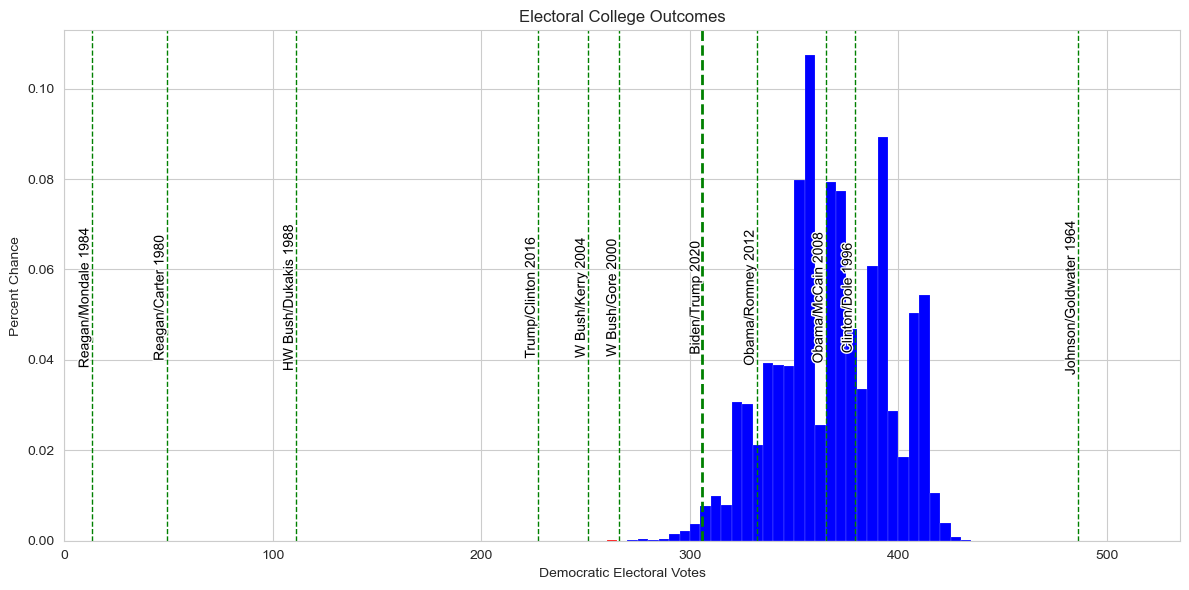

In [111]:
plt.figure(figsize=(12, 6))

bins = list(range(0, 269, 5)) + [269] + list(range(270, 540, 5))

ax = sns.histplot(df_ec['dem'], bins=bins, kde=False, stat="probability")

max_height = max([patch.get_height() for patch in ax.patches])
lowest_bar = min([patch.get_x() for patch in ax.patches])
highest_bar = max([patch.get_x() + patch.get_width() for patch in ax.patches])

for patch in ax.patches:
    x = patch.get_x()
    
    if x < 269:
        patch.set_facecolor('red')
    elif x > 269:
        patch.set_facecolor('blue')
    elif x == 269:
        patch.set_facecolor('lime')
    else:
        patch.set_facecolor('lime')

plt.title('Electoral College Outcomes')
plt.xlabel('Democratic Electoral Votes')
plt.xlim(lowest_bar, highest_bar)
plt.ylabel('Percent Chance')

events = [
    (13, 'Reagan/Mondale 1984'),
    (49, 'Reagan/Carter 1980'),
    (111, 'HW Bush/Dukakis 1988'),
    (227, 'Trump/Clinton 2016'),
    (251, 'W Bush/Kerry 2004'),
    (266, 'W Bush/Gore 2000'),
    (306, 'Biden/Trump 2020'),
    (332, 'Obama/Romney 2012'),
    (365, 'Obama/McCain 2008'),
    (379, 'Clinton/Dole 1996'),
    (486, 'Johnson/Goldwater 1964')
]

label_position = 1/2 * max_height

for date, event in events:
        if str(year) in event:
            color = 'green'
            linewidth = 2
        else:
            color = 'green'
            linewidth = 1
        ax.axvline(x=date, color=color, linestyle='--', linewidth=linewidth)
        text = ax.text(date, label_position, event, rotation=90, verticalalignment='center', 
                       horizontalalignment='right', fontsize=10, color='black')
        text.set_path_effects([
            path_effects.Stroke(linewidth=2, foreground='white'),
            path_effects.Normal()
        ])

plt.tight_layout()
plt.savefig(f'../Results/{year}_president/electoral_vote_margin.png')

In [112]:
df_margin = pd.DataFrame(columns=states)
df_gop = pd.DataFrame(columns=states)
df_dem = pd.DataFrame(columns=states)
df_oth = pd.DataFrame(columns=states)

for state in states:
    df_margin[state] = df_results[f"{state}_margin"]
    df_gop[state] = df_results[f"{state}_gop"]
    df_dem[state] = df_results[f"{state}_dem"]

df_mean = pd.DataFrame(columns=parties)
df_mean['dem'] = df_dem.mean()
df_mean['gop'] = df_gop.mean()
df_mean['margin'] = df_margin.mean()

In [113]:
df_win_pct = pd.DataFrame()
df_win_pct['dem'] = df_winner_dem.mean(axis=0)
df_win_pct['gop'] = df_winner_gop.mean(axis=0)

In [114]:
print("Safe D: ")
print(df_win_pct.query("dem >= .98").index.sort_values().values)
print("Likely D: ")
print(df_win_pct.query("(dem < .98) and (dem >= .75)").index.sort_values().values)
print("Leans D: ")
print(df_win_pct.query("(dem < .75) and (dem >= .6)").index.sort_values().values)
print("Tilt D: ")
print(df_win_pct.query("(dem < .6) and (dem >= .5)").index.sort_values().values)
print("Tilt R: ")
print(df_win_pct.query("(gop < .6) and (gop >= .5)").index.sort_values().values)
print("Leans R: ")
print(df_win_pct.query("(gop < .75) and (gop >= .6)").index.sort_values().values)
print("Likely R: ")
print(df_win_pct.query("(gop < .98) and (gop >= .75)").index.sort_values().values)
print("Safe R: ")
print(df_win_pct.query("gop >= .98").index.sort_values().values)

Safe D: 
['CA' 'CO' 'CT' 'DC' 'DE' 'HI' 'IL' 'MA' 'MD' 'ME' 'ME-1' 'MI' 'MN' 'NH'
 'NJ' 'NM' 'NY' 'OR' 'RI' 'US' 'VA' 'VT' 'WA' 'WI']
Likely D: 
['AZ' 'FL' 'GA' 'ME-2' 'NC' 'NV' 'PA']
Leans D: 
[]
Tilt D: 
['IA']
Tilt R: 
['OH' 'TX']
Leans R: 
[]
Likely R: 
['KS' 'MT' 'SC']
Safe R: 
['AK' 'AL' 'AR' 'ID' 'IN' 'KY' 'LA' 'MO' 'MS' 'ND' 'NE' 'NE-1' 'NE-2'
 'NE-3' 'OK' 'SD' 'TN' 'UT' 'WV' 'WY']


In [115]:
pct_dem_wo_pop = 100*len(df_ec.query("(gop_pop == 1) & (dem > 269)"))/len(df_ec)
pct_gop_wo_pop = 100*len(df_ec.query("(dem_pop == 1) & (gop > 269)"))/len(df_ec)

print("% Chance of a Win in Electoral College")
print("--------------------------------------")
print(" Democrats:   " + f"{round(percent_greater_than_270,2):6.2f}" + "%")
print(" Tie:         " + f"{round(percent_equal_to_270,2):6.2f}" + "%")
print(" Republicans: " + f"{round(percent_lower_than_270,2):6.2f}" + "%")
print()
print("Electoral College Estimates")
print("---------------------------")
print("  %  |  DEM  |  GOP  | Margin ")
print("  3% |  "+ f"{df_ec.dem.quantile(0.03):.0f}" + "  |  "+ f"{df_ec.gop.quantile(0.97):.0f}" + "  |  "+ f"{round(df_ec.dem.quantile(0.03) - df_ec.gop.quantile(0.97), 2):4.0f}")
print(" 25% |  "+ f"{df_ec.dem.quantile(0.25):.0f}" + "  |  "+ f"{df_ec.gop.quantile(0.75):.0f}" + "  |  "+ f"{round(df_ec.dem.quantile(0.25) - df_ec.gop.quantile(0.75), 2):4.0f}")
print(" 50% |  "+ f"{df_ec.dem.quantile(0.50):.0f}" + "  |  "+ f"{df_ec.gop.quantile(0.50):.0f}" + "  |  "+ f"{round(df_ec.dem.quantile(0.50) - df_ec.gop.quantile(0.50), 2):4.0f}")
print(" 75% |  "+ f"{df_ec.dem.quantile(0.75):.0f}" + "  |  "+ f"{df_ec.gop.quantile(0.25):.0f}" + "  |  "+ f"{round(df_ec.dem.quantile(0.75) - df_ec.gop.quantile(0.25), 2):4.0f}")
print(" 97% |  "+ f"{df_ec.dem.quantile(0.97):.0f}" + "  |  "+ f"{df_ec.gop.quantile(0.03):.0f}" + "  |  "+ f"{round(df_ec.dem.quantile(0.97) - df_ec.gop.quantile(0.03), 2):4.0f}")
print()
print("% Chance of Popular Vote Win")
print("----------------------------")
print(" Democrats:   " + f"{round(df_winner_dem.US.mean()*100,2):6.2f}" + "%")
print(" Republicans: " + f"{round(df_winner_gop.US.mean()*100,2):6.2f}" + "%")
print()
print("% Chance of a Win without Popular Vote")
print("--------------------------------------")
print(" Democrats:   " + f"{round(pct_dem_wo_pop,2):6.2f}" + "%")
print(" Republicans: " + f"{round(pct_gop_wo_pop,2):6.2f}" + "%")
print(" Total:       " + f"{round(pct_dem_wo_pop+pct_gop_wo_pop,2):6.2f}" + "%")
print()
print("Popular Vote Estimates")
print("----------------------")
print("  %  |  DEM  |  GOP  | Margin ")
print("  3% | "+ f"{df_dem.US.quantile(0.03) * 100:.2f}" + " | "+ f"{df_gop.US.quantile(0.97) * 100:.2f}" + " |"+ f"{round(df_dem.US.quantile(0.03) * 100 - df_gop.US.quantile(0.97) * 100, 2):6.2f}")
print(" 25% | "+ f"{df_dem.US.quantile(0.25) * 100:.2f}" + " | "+ f"{df_gop.US.quantile(0.75) * 100:.2f}" + " |"+ f"{round(df_dem.US.quantile(0.25) * 100 - df_gop.US.quantile(0.75) * 100, 2):6.2f}")
print(" 50% | "+ f"{df_dem.US.quantile(0.50) * 100:.2f}" + " | "+ f"{df_gop.US.quantile(0.50) * 100:.2f}" + " |"+ f"{round(df_dem.US.quantile(0.50) * 100 - df_gop.US.quantile(0.50) * 100, 2):6.2f}")
print(" 75% | "+ f"{df_dem.US.quantile(0.75) * 100:.2f}" + " | "+ f"{df_gop.US.quantile(0.25) * 100:.2f}" + " |"+ f"{round(df_dem.US.quantile(0.75) * 100 - df_gop.US.quantile(0.25) * 100, 2):6.2f}")
print(" 97% | "+ f"{df_dem.US.quantile(0.97) * 100:.2f}" + " | "+ f"{df_gop.US.quantile(0.03) * 100:.2f}" + " |"+ f"{round(df_dem.US.quantile(0.97) * 100 - df_gop.US.quantile(0.03) * 100, 2):6.2f}")

% Chance of a Win in Electoral College
--------------------------------------
 Democrats:    99.99%
 Tie:           0.00%
 Republicans:   0.01%

Electoral College Estimates
---------------------------
  %  |  DEM  |  GOP  | Margin 
  3% |  318  |  220  |    98
 25% |  350  |  188  |   162
 50% |  368  |  170  |   198
 75% |  390  |  148  |   242
 97% |  412  |  126  |   286

% Chance of Popular Vote Win
----------------------------
 Democrats:   100.00%
 Republicans:   0.00%

% Chance of a Win without Popular Vote
--------------------------------------
 Democrats:     0.00%
 Republicans:   0.01%
 Total:         0.01%

Popular Vote Estimates
----------------------
  %  |  DEM  |  GOP  | Margin 
  3% | 49.51 | 44.71 |  4.81
 25% | 50.71 | 43.57 |  7.14
 50% | 51.38 | 42.93 |  8.44
 75% | 52.05 | 42.28 |  9.77
 97% | 53.20 | 41.17 | 12.03


In [116]:
margin_and_ec = pd.DataFrame()
margin_and_ec['pop'] = df_results.US_margin
margin_and_ec['ec'] = df_ec.dem - df_ec.gop

margin_and_ec = margin_and_ec.groupby('ec').agg(
    count=('pop', 'size'),
    pop=('pop', 'mean')
).reset_index().sort_values("count", ascending = False)

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_54268/3238150372.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = results.params[1]
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_54268/3238150372.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = results.params[0]


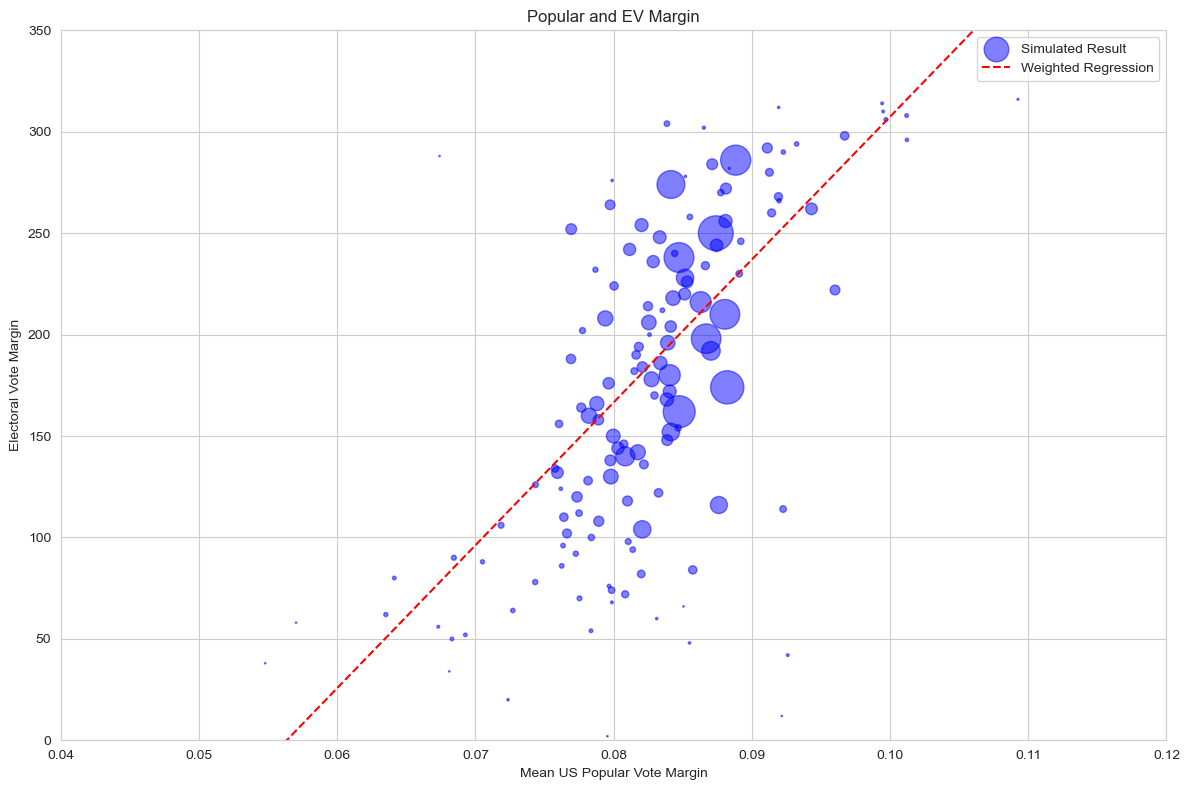

In [136]:
fig, ax = plt.subplots(figsize=(12, 8))

plt.scatter(margin_and_ec['pop'], margin_and_ec['ec'], 
            s=margin_and_ec['count'], color='blue', alpha=0.5, label='Simulated Result')

X = margin_and_ec['pop']
y = margin_and_ec['ec']
weights = margin_and_ec['count']

X = sm.add_constant(X)

wls_model = sm.WLS(y, X, weights=weights)
results = wls_model.fit()

slope = results.params[1]
intercept = results.params[0]

x_vals = np.array(plt.gca().get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, color='red', linestyle='--', label='Weighted Regression')

ax.set_ylim(0, 350)
ax.set_xlim(0.04, 0.12)

plt.xlabel('Mean US Popular Vote Margin')
plt.ylabel('Electoral Vote Margin')
plt.title('Popular and EV Margin')

plt.legend()

plt.tight_layout()
plt.savefig(f'../Results/{year}_president/electoral_college_adv.png')

In [118]:
print("Electoral College Advantage: "+f"{100*-intercept/slope:.2f}"+"%")

Electoral College Advantage: 5.63%


In [119]:
df_winp = df_results.filter(regex='_margin$')
df_winp.columns = df_winp.columns.str.replace('_margin$', '', regex=True)
df_winp = df_winp.map(lambda x: 0 if x < 0 else 1)

df_winp = df_winp.merge(df_ec[['dem_ec','dem', 'gop']], left_index=True, right_index=True, how='left')
df_winp['us_margin'] = df_dem.US-df_gop.US

In [120]:
df_margin = pd.DataFrame()
df_margin['hdi_03'] = (df_dem - df_gop).quantile(0.03)
df_margin['hdi_25'] = (df_dem - df_gop).quantile(0.25)
df_margin['hdi_mean'] = (df_dem - df_gop).quantile(0.50)
df_margin['hdi_75'] = (df_dem - df_gop).quantile(0.75)
df_margin['hdi_97'] = (df_dem - df_gop).quantile(0.97)

df_margin['state_code'] = df_dem.columns.values
df_margin = df_margin.merge(df_win_pct,left_index=True, right_index=True)
df_margin = df_margin.merge(df_actual_results[['margin','State']].set_index('State'),left_index=True, right_index=True)

df_margin['scale'] = 10

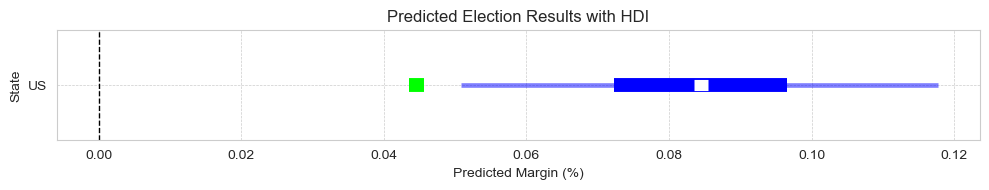

In [121]:
chart_df = df_margin.query("state_code == 'US'").sort_values(by='hdi_mean')
scale_factor = 1

cumulative_votes = np.cumsum(chart_df['scale'] * scale_factor)
y_positions = cumulative_votes - (chart_df['scale'] * scale_factor / 2)

plt.figure(figsize=(10, 2))

for i, row in chart_df.iterrows():
    plt.hlines(y=y_positions[i], xmin=row['hdi_mean']-.001, xmax=row['hdi_mean']+.001, color='white', alpha=1, linewidth=row['scale'] * scale_factor*.8, zorder=5)
    plt.hlines(y=y_positions[i], xmin=row['margin']-.001, xmax=row['margin']+.001, color='lime', alpha=1, linewidth=row['scale'] * scale_factor, zorder=5)
    if row['hdi_75'] > 0 and row['hdi_25'] < 0:
        plt.hlines(y_positions[i], row['hdi_25'], 0, color='red', linewidth=row['scale'] * scale_factor, zorder=3)
        plt.hlines(y_positions[i], 0, row['hdi_75'], color='blue', linewidth=row['scale'] * scale_factor, zorder=3)
    elif row['hdi_25'] >= 0:
        plt.hlines(y_positions[i], row['hdi_25'], row['hdi_75'], color='blue', linewidth=row['scale'] * scale_factor, zorder=3)
    elif row['hdi_75'] <= 0:
        plt.hlines(y_positions[i], row['hdi_25'], row['hdi_75'], color='red', linewidth=row['scale'] * scale_factor, zorder=3)
    if row['hdi_97'] > 0 and row['hdi_03'] < 0:
        plt.hlines(y_positions[i], row['hdi_03'], 0, color='red', alpha=0.5, linewidth=row['scale'] * scale_factor / 3, zorder=3)
        plt.hlines(y_positions[i], 0, row['hdi_97'], color='blue', alpha=0.5, linewidth=row['scale'] * scale_factor / 3, zorder=3)
    elif row['hdi_03'] >= 0:
        plt.hlines(y_positions[i], row['hdi_03'], row['hdi_97'], color='blue', alpha=0.5, linewidth=row['scale'] * scale_factor / 3, zorder=3)
    elif row['hdi_97'] <= 0:
        plt.hlines(y_positions[i], row['hdi_03'], row['hdi_97'], color='red', alpha=0.5, linewidth=row['scale'] * scale_factor / 3, zorder=3)

plt.axvline(x=0, color='black', linewidth=1, linestyle='--', zorder=1)

plt.yticks(y_positions, chart_df['state_code'])

plt.xlabel('Predicted Margin (%)')
plt.ylabel('State')
plt.title('Predicted Election Results with HDI')

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()

plt.savefig(f'../Results/{year}_president/hdi_us.png')

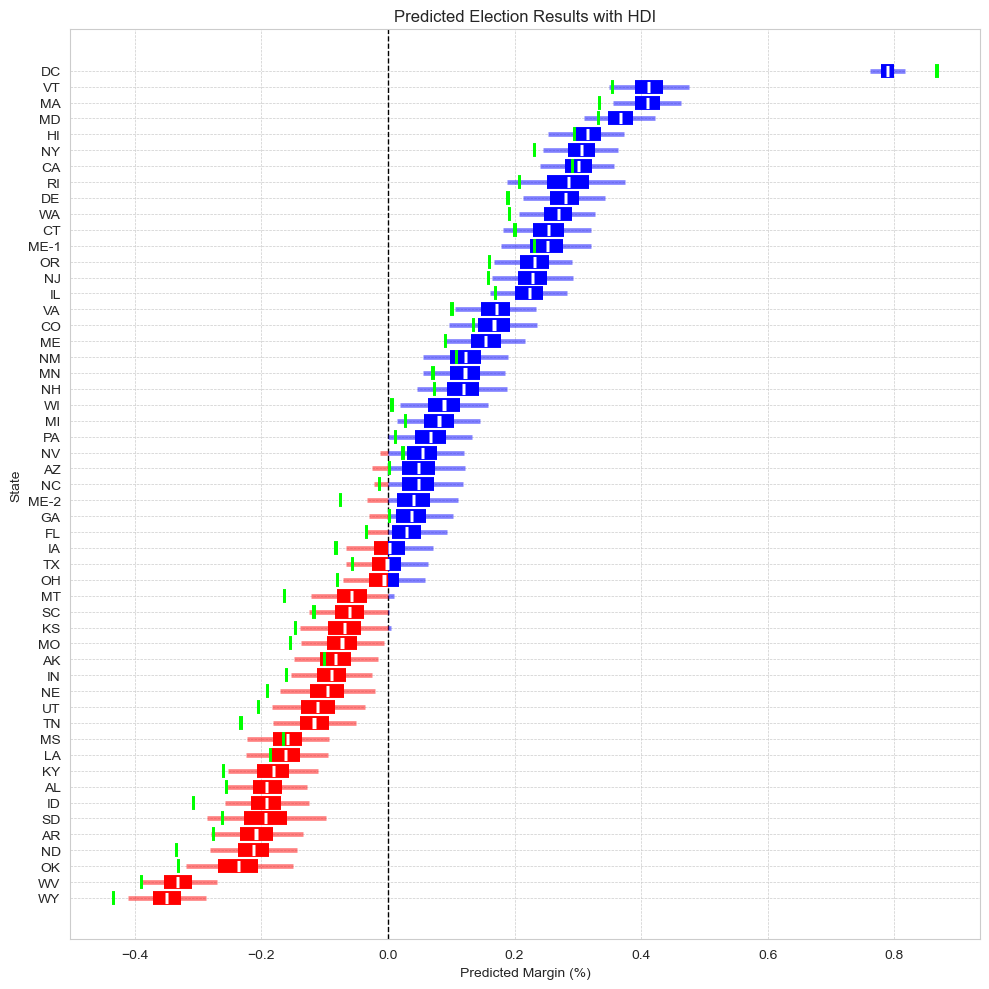

In [122]:
chart_df = df_margin.query("state_code != 'US'").sort_values(by='hdi_mean')
scale_factor = 1

cumulative_votes = np.cumsum(chart_df['scale'] * scale_factor)
y_positions = cumulative_votes - (chart_df['scale'] * scale_factor / 2)

plt.figure(figsize=(10, 10))

for i, row in chart_df.iterrows():
    plt.hlines(y=y_positions[i], xmin=row['hdi_mean']-.0025, xmax=row['hdi_mean']+.0025, color='white', alpha=1, linewidth=row['scale'] * scale_factor*.8, zorder=5)
    plt.hlines(y=y_positions[i], xmin=row['margin']-.0025, xmax=row['margin']+.0025, color='lime', alpha=1, linewidth=row['scale'] * scale_factor, zorder=5)
    if row['hdi_75'] > 0 and row['hdi_25'] < 0:
        plt.hlines(y_positions[i], row['hdi_25'], 0, color='red', linewidth=row['scale'] * scale_factor, zorder=3)
        plt.hlines(y_positions[i], 0, row['hdi_75'], color='blue', linewidth=row['scale'] * scale_factor, zorder=3)
    elif row['hdi_25'] >= 0:
        plt.hlines(y_positions[i], row['hdi_25'], row['hdi_75'], color='blue', linewidth=row['scale'] * scale_factor, zorder=3)
    elif row['hdi_75'] <= 0:
        plt.hlines(y_positions[i], row['hdi_25'], row['hdi_75'], color='red', linewidth=row['scale'] * scale_factor, zorder=3)
    if row['hdi_97'] > 0 and row['hdi_03'] < 0:
        plt.hlines(y_positions[i], row['hdi_03'], 0, color='red', alpha=0.5, linewidth=row['scale'] * scale_factor / 3, zorder=3)
        plt.hlines(y_positions[i], 0, row['hdi_97'], color='blue', alpha=0.5, linewidth=row['scale'] * scale_factor / 3, zorder=3)
    elif row['hdi_03'] >= 0:
        plt.hlines(y_positions[i], row['hdi_03'], row['hdi_97'], color='blue', alpha=0.5, linewidth=row['scale'] * scale_factor / 3, zorder=3)
    elif row['hdi_97'] <= 0:
        plt.hlines(y_positions[i], row['hdi_03'], row['hdi_97'], color='red', alpha=0.5, linewidth=row['scale'] * scale_factor / 3, zorder=3)

plt.axvline(x=0, color='black', linewidth=1, linestyle='--', zorder=1)

plt.yticks(y_positions, chart_df['state_code'])

plt.xlabel('Predicted Margin (%)')
plt.ylabel('State')
plt.title('Predicted Election Results with HDI')

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()

plt.savefig(f'../Results/{year}_president/hdi_all.png')

In [123]:
df_margin['error'] =  df_margin.hdi_mean - df_margin.margin

df_margin = pd.merge(df_margin, pd.DataFrame(df.state.value_counts()),
         how="left",
         left_on='state_code',
         right_index=True)

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_54268/2100134960.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = results.params[1]
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_54268/2100134960.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = results.params[0]
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_54268/2100134960.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[p

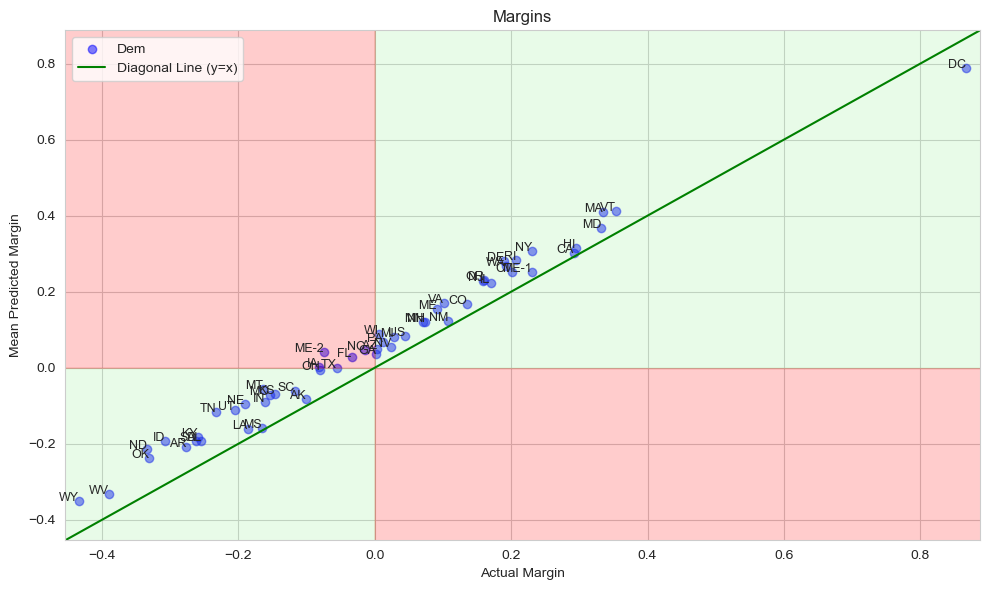

In [124]:
fig, ax = plt.subplots(figsize=(10, 6))

plt.scatter(df_margin['margin'], df_margin['hdi_mean'], 
            color='blue', alpha=0.5, label='Dem')

import statsmodels.api as sm
import scipy.stats as stats

X = df_margin['margin']
y = df_margin['hdi_mean']
weights = df_margin['count']

X = sm.add_constant(X)

wls_model = sm.WLS(y, X, weights=weights)
results = wls_model.fit()

slope = results.params[1]
intercept = results.params[0]

x_vals = np.array(plt.gca().get_xlim())
y_vals = intercept + slope * x_vals

plt.plot(x_vals, x_vals, color='green', linestyle='-', label='Diagonal Line (y=x)')

ax.set_xlim(df_margin[['margin','hdi_mean']].min().min()-.02, df_margin[['margin','hdi_mean']].max().max()+.02)
ax.set_ylim(df_margin[['margin','hdi_mean']].min().min()-.02, df_margin[['margin','hdi_mean']].max().max()+.02)

ax.fill_betweenx(y=np.arange(0, 1, 0.001), x1=0, x2=1, color='lightgreen', alpha=0.2)
ax.fill_betweenx(y=np.arange(-1, 0, 0.001), x1=-1, x2=0, color='lightgreen', alpha=0.2)
ax.fill_betweenx(y=np.arange(0, 1, 0.001), x1=-1, x2=0, color='red', alpha=0.2)
ax.fill_betweenx(y=np.arange(-1, 0, 0.001), x1=0, x2=1, color='red', alpha=0.2)

xlim = ax.get_xlim()
ylim = ax.get_ylim()

for i, state in enumerate(df_margin['state_code']):
    x_val = df_margin['margin'][i]
    y_val = df_margin['hdi_mean'][i]
    if (xlim[0] <= x_val <= xlim[1] and ylim[0] <= y_val <= ylim[1]):
        plt.text(df_margin['margin'][i], df_margin['hdi_mean'][i], state, fontsize=9, ha='right')

plt.xlabel('Actual Margin')
plt.ylabel('Mean Predicted Margin')
plt.title('Margins')

plt.legend()

plt.tight_layout()
plt.savefig(f'../Results/{year}_president/margins.png')

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_54268/3371754012.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_val = df_margin['margin'][i]
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_54268/3371754012.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_val = df_margin['hdi_mean'][i]
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_54268/3371754012.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

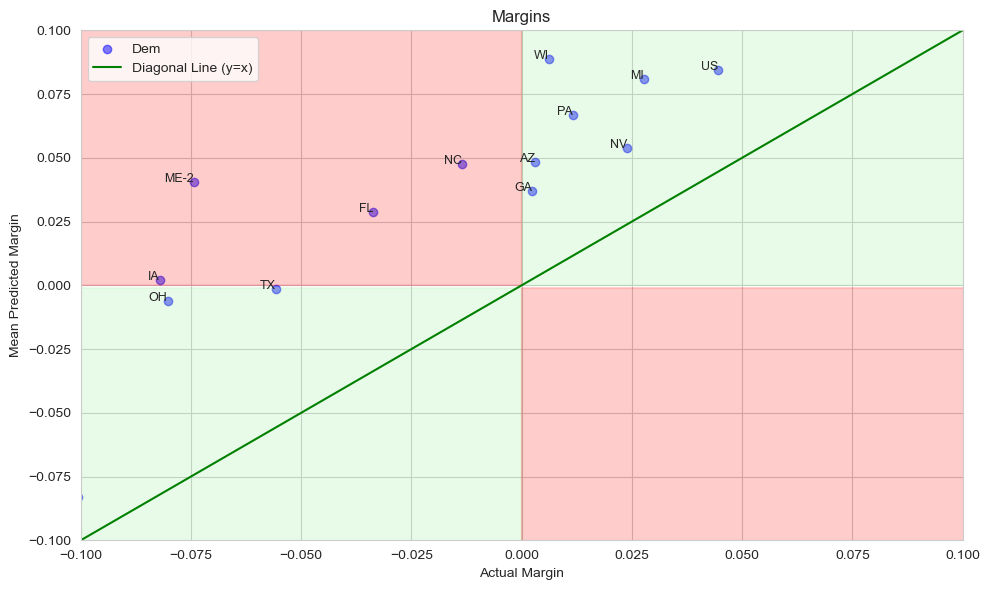

In [125]:
fig, ax = plt.subplots(figsize=(10, 6))

plt.scatter(df_margin['margin'], df_margin['hdi_mean'], 
            color='blue', alpha=0.5, label='Dem')

x_vals = np.array(plt.gca().get_xlim())
y_vals = intercept + slope * x_vals

plt.plot(x_vals, x_vals, color='green', linestyle='-', label='Diagonal Line (y=x)')

ax.set_xlim(-.1, .1)
ax.set_ylim(-.1, .1)

ax.fill_betweenx(y=np.arange(0, 1, 0.001), x1=0, x2=1, color='lightgreen', alpha=0.2)
ax.fill_betweenx(y=np.arange(-1, 0, 0.001), x1=-1, x2=0, color='lightgreen', alpha=0.2)
ax.fill_betweenx(y=np.arange(0, 1, 0.001), x1=-1, x2=0, color='red', alpha=0.2)
ax.fill_betweenx(y=np.arange(-1, 0, 0.001), x1=0, x2=1, color='red', alpha=0.2)

xlim = ax.get_xlim()
ylim = ax.get_ylim()

for i, state in enumerate(df_margin['state_code']):
    x_val = df_margin['margin'][i]
    y_val = df_margin['hdi_mean'][i]
    if (xlim[0] <= x_val <= xlim[1] and ylim[0] <= y_val <= ylim[1]):
        plt.text(df_margin['margin'][i], df_margin['hdi_mean'][i], state, fontsize=9, ha='right')

plt.xlabel('Actual Margin')
plt.ylabel('Mean Predicted Margin')
plt.title('Margins')

plt.legend()

plt.tight_layout()
plt.savefig(f'../Results/{year}_president/margins_zoom.png')

In [126]:
calc_slope = 1/slope
calc_intercept = intercept

In [127]:
calc_slope

1.0959790116376837

In [128]:
calc_intercept

0.056141978275668046

In [129]:
df_margin['mean_corrected'] = df_margin.hdi_mean*calc_slope-calc_intercept
df_margin['error_corrected'] =  df_margin.mean_corrected - df_margin.margin

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_54268/1236335707.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = results.params[1]
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_54268/1236335707.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = results.params[0]
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_54268/1236335707.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[p

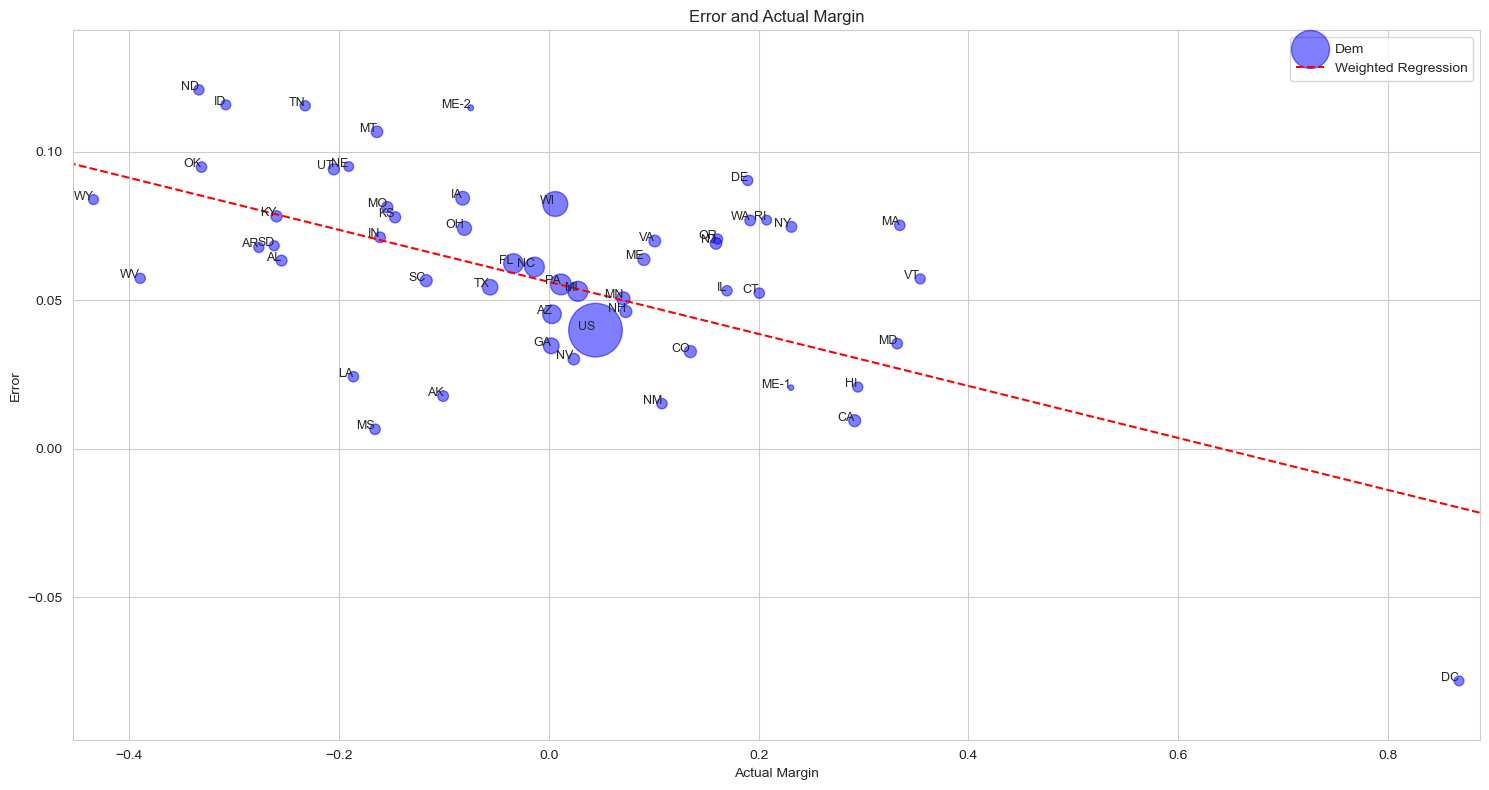

In [130]:
fig, ax = plt.subplots(figsize=(15, 8))

plt.scatter(df_margin['margin'], df_margin['error'], 
             s=df_margin['count'], color='blue', alpha=0.5, label='Dem')

X = df_margin['margin']
y = df_margin['error']
weights = df_margin['count']

X = sm.add_constant(X)

wls_model = sm.WLS(y, X, weights=weights)
results = wls_model.fit()

slope = results.params[1]
intercept = results.params[0]

x_vals = np.array(plt.gca().get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, color='red', linestyle='--', label='Weighted Regression')

ax.set_xlim(df_margin['margin'].min()-.02, df_margin['margin'].max()+.02)
ax.set_ylim(df_margin['error'].min()-.02, df_margin['error'].max()+.02)

xlim = ax.get_xlim()
ylim = ax.get_ylim()

for i, state in enumerate(df_margin['state_code']):
    x_val = df_margin['margin'][i]
    y_val = df_margin['error'][i]
    if (xlim[0] <= x_val <= xlim[1] and ylim[0] <= y_val <= ylim[1]):
        plt.text(df_margin['margin'][i], df_margin['error'][i], state, fontsize=9, ha='right')

plt.xlabel('Actual Margin')
plt.ylabel('Error')
plt.title('Error and Actual Margin')

plt.legend()

plt.tight_layout()
plt.savefig(f'../Results/{year}_president/error.png')

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_54268/4277828861.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = results.params[1]
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_54268/4277828861.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = results.params[0]
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_54268/4277828861.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[p

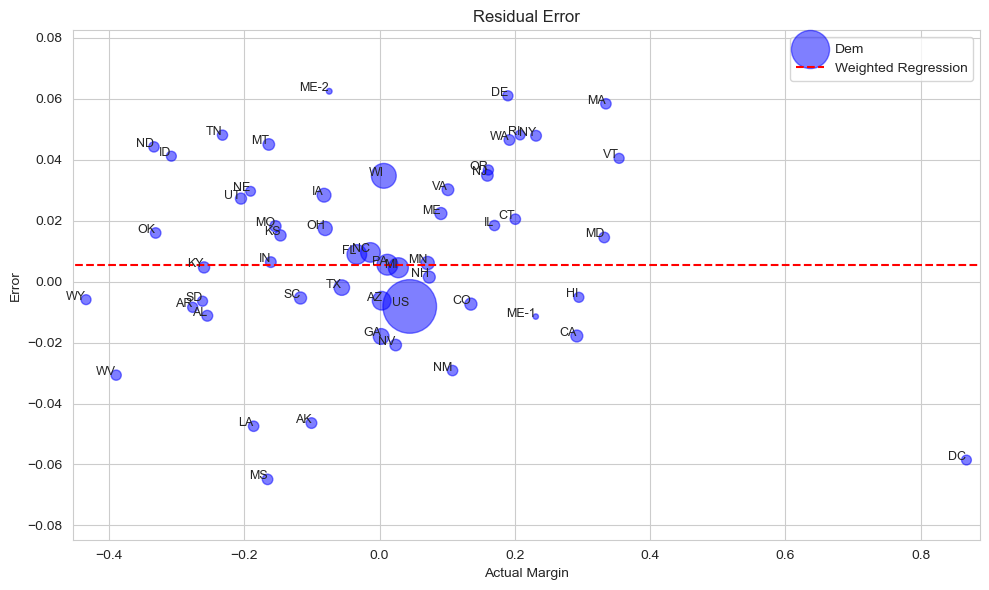

In [131]:
fig, ax = plt.subplots(figsize=(10, 6))

plt.scatter(df_margin['margin'], df_margin['error_corrected'], 
             s=df_margin['count'], color='blue', alpha=0.5, label='Dem')

X = df_margin['margin']
y = df_margin['error_corrected']
weights = df_margin['count']

X = sm.add_constant(X)

wls_model = sm.WLS(y, X, weights=weights)
results = wls_model.fit()

slope = results.params[1]
intercept = results.params[0]

x_vals = np.array(plt.gca().get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, color='red', linestyle='--', label='Weighted Regression')

ax.set_xlim(df_margin['margin'].min()-.02, df_margin['margin'].max()+.02)
ax.set_ylim(df_margin['error_corrected'].min()-.02, df_margin['error_corrected'].max()+.02)

xlim = ax.get_xlim()
ylim = ax.get_ylim()

for i, state in enumerate(df_margin['state_code']):
    x_val = df_margin['margin'][i]
    y_val = df_margin['error_corrected'][i]
    if (xlim[0] <= x_val <= xlim[1] and ylim[0] <= y_val <= ylim[1]):
        plt.text(df_margin['margin'][i], df_margin['error_corrected'][i], state, fontsize=9, ha='right')

plt.xlabel('Actual Margin')
plt.ylabel('Error')
plt.title('Residual Error')

plt.legend()

plt.tight_layout()
plt.savefig(f'../Results/{year}_president/error_corrected.png')

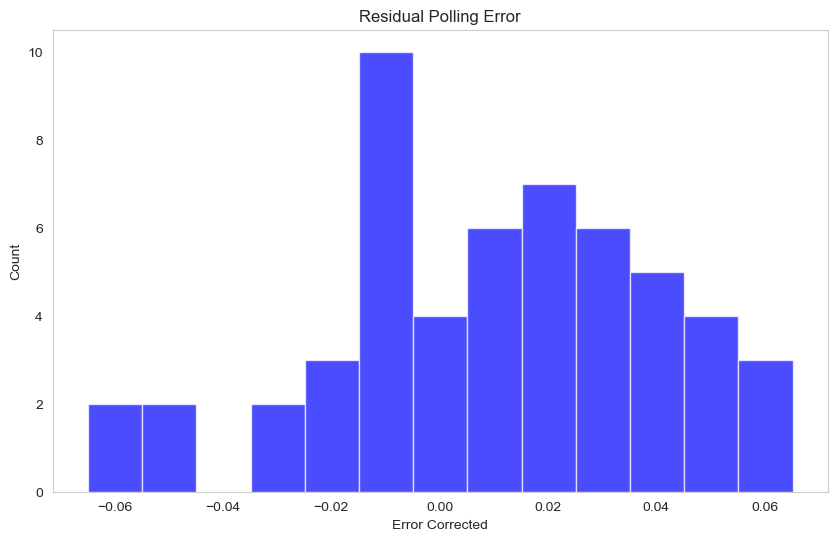

In [132]:
plt.figure(figsize=(10, 6))

bin_width = 0.01
min_edge = df_margin['error_corrected'].min()
max_edge = df_margin['error_corrected'].max()
bins = np.arange(min_edge, max_edge + bin_width, bin_width)

plt.hist(df_margin['error_corrected'], bins=bins, alpha=0.7, color='blue')

plt.xlabel('Error Corrected')
plt.ylabel('Count')
plt.title('Residual Polling Error')
plt.grid()


plt.savefig(f'../Results/{year}_president/error_hist.png')

In [133]:
df_margin['error_corrected'].std()

0.02993515095210651

In [134]:
df_swing = df_state[['state_code',f'electoral_{year}']]
df_swing = df_swing.merge(df_margin.hdi_mean,left_on='state_code', right_index=True, how='left')
df_swing.loc[df_swing['state_code'].isin(blue_states), 'hdi_mean'] = 1
df_swing.loc[df_swing['state_code'].isin(red_states), 'hdi_mean'] = -1
df_swing.loc[df_swing['state_code'].isin(['ME-1','ME-2']), 'hdi_mean'] = df_swing.loc[df_swing['state_code'].isin(['ME']), 'hdi_mean'].values[0]
df_swing = df_swing.sort_values(by='hdi_mean')
df_swing['running_sum'] = df_swing[f'electoral_{year}'].cumsum()
df_swing['swing_score'] = ((df_swing['running_sum'] - 269)**2)**.5

df_swing.loc[
    (~df_swing['state_code'].isin(['US'])) & (df_swing['swing_score'] <= 50)
].sort_values(by='swing_score')

,state_code,electoral_2020,hdi_mean,running_sum,swing_score
34,NV,6,0.054045,262,7.0
2,AZ,11,0.048335,256,13.0
44,PA,20,0.066877,282,13.0
39,NC,15,0.047654,245,24.0
24,MI,16,0.080757,298,29.0
10,GA,16,0.037002,230,39.0
55,WI,10,0.088652,308,39.0
35,NH,4,0.119637,312,43.0
